# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
import time
time.sleep(int(60*60*0)) #wait 0h

In [2]:
import math
def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

In [3]:
d = 3  
n = 4
sparsity = nCr(n+d, d)

x_max = 1#10 #this number excluded
x_min = -1#-10
x_step = 0.01#0.1
a_max = 10 #this number excluded
a_min = -10
a_step = 0.001

n_jobs = 11


data_size = 500000 #for loading lambda models

#specify interpretation net structure
optimizer = 'custom'#adam
dropout = 0.25
epochs = 100
batch_size = 512
interpretation_network_layers = [512, 1024]

random_evaluation_dataset_size = 500

#lambda net specifications for loading (need to be set according to lambda net training to load correct weights)
epochs_lambda = 200
batch_lambda = 64
lambda_network_layers = [5*sparsity]
optimizer_lambda = '_' + 'SGD'


lambda_dataset_size = 1000

#set if multi_epoch_analysis should be performed
multi_epoch_analysis = False
each_epochs_save_lambda = 20
epoch_start = 0 #use to skip first epochs in multi_epoch_analysis

#set if samples analysis should be performed
samples_list = None#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 

evaluate_with_real_function = True
consider_labels_training = False

same_training_all_lambda_nets = False

fixed_seed_lambda_training = False
fixed_initialization_lambda_training = False
number_different_lambda_trainings = 500

inet_holdout_seed_evaluation = False
seed_in_inet_training = False


In [4]:
##############DO NOT CHANGE###################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n] 
RANDOM_SEED = 42

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

advanced_metric_dataset_size = 10#200

use_gpu = False
if use_gpu:
    gpu_numbers = '0'
else:
    gpu_numbers = ''

if fixed_seed_lambda_training:
    seed_shuffle_string = '_' + str(number_different_lambda_trainings) + '-FixedSeed'
else:
    seed_shuffle_string = '_NoFixedSeed'
    
if fixed_initialization_lambda_training:
    seed_shuffle_string += '_' + str(number_different_lambda_trainings) + '-FixedEvaluation'
else:
    seed_shuffle_string += '_NoFixedEvaluation'

if same_training_all_lambda_nets:
    training_string = '_same'
else:
    training_string = '_diverse'

layers_str = ''.join([str(neurons) + '-' for neurons in lambda_network_layers])

structure = '_' + layers_str + str(epochs_lambda) + 'e' + str(batch_lambda) + 'b' + optimizer_lambda
filename = seed_shuffle_string + '_' + str(RANDOM_SEED) + structure

interpretation_network_string = 'drop' + str(dropout) + 'e' + str(epochs) + 'b' + str(batch_size) + '_' + str(interpretation_network_layers)


## Imports

In [5]:
import ttg
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer


import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers
import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

import tensorflow as tf
import random 
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 50)

try:
    # Create target Directory
    os.mkdir('./data/plotting/' + interpretation_network_string + filename + '/')
    os.mkdir('./data/results/' + interpretation_network_string + filename + '/')
except FileExistsError:
    pass

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Math, Latex


In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

In [7]:
#General Utility Functions

ALPHABET = \
  "0123456789abcdefghijklmnopqrstuvwxyz"

def encode (n):
    try:
        return ALPHABET [n]
    except IndexError:
        raise Exception ("cannot encode: %s" % n)
        
def dec_to_base (dec = 0, base = 16):
    if dec < base:
        return encode (dec)
    else:
        return dec_to_base (dec // base, base) + encode (dec % base)

def return_float_tensor_representation(some_representation, dtype=tf.float32):
    if tf.is_tensor(some_representation):
        some_representation = tf.dtypes.cast(some_representation, dtype) 
    else:
        some_representation = tf.convert_to_tensor(some_representation)
        some_representation = tf.dtypes.cast(some_representation, dtype) 
        
    if not tf.is_tensor(some_representation):
        raise SystemExit('Given variable is no instance of ' + str(dtype) + ':' + str(some_representation))
     
    return some_representation


def return_numpy_representation(some_representation):
    if isinstance(some_representation, pd.DataFrame):
        some_representation = some_representation.values
        
    if isinstance(some_representation, list):
        some_representation = np.array(some_representation)
    
    if not isinstance(some_representation, np.ndarray):
        raise SystemExit('Given variable is no instance of ' + str(np.ndarray) + ':' + str(some_representation))
    
    return some_representation

def mergeDict(dict1, dict2):
    #Merge dictionaries and keep values of common keys in list
    newDict = {**dict1, **dict2}
    for key, value in newDict.items():
        if key in dict1 and key in dict2:
            if isinstance(dict1[key], list) and isinstance(value, list):
                newDict[key] = dict1[key]
                newDict[key].extend(value)
            elif isinstance(dict1[key], list) and not isinstance(value, list):
                newDict[key] = dict1[key]
                newDict[key].extend([value])
            elif not isinstance(dict1[key], list) and isinstance(value, list):
                newDict[key] = [dict1[key]]
                newDict[key].extend(value)
            else:
                newDict[key] = [dict1[key], value]
    return newDict

def return_callbacks_from_string(callback_string_list):
    callbacks = [] if len(callback_string_list) > 0 else None
    #if 'plot_losses_callback' in callback_string_list:
        #callbacks.append(PlotLossesCallback())
    if 'reduce_lr_loss' in callback_string_list:
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=epochs/10, verbose=0, min_delta=0, mode='min') #epsilon
        callbacks.append(reduce_lr_loss)
    if 'early_stopping' in callback_string_list:
        earlyStopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0, verbose=0, mode='min')
        callbacks.append(earlyStopping)
        
    #if not multi_epoch_analysis and samples_list == None: 
        #callbacks.append(TQDMNotebookCallback())
        
    return callbacks

def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if np.array_equal(elem, myarr)), False)

def generate_random_x_values(size, x_max, x_min, x_step, numnber_of_variables, seed=42):
    
    if random.seed != None:
        random.seed(seed)
    
    x_values_list = []
    
    for j in range(size):
        values = np.round(np.array(random_product(np.arange(x_min, x_max, x_step), repeat=numnber_of_variables)), int(-np.log10(x_step)))
        while arreq_in_list(values, x_values_list):
                values = np.round(np.array(random_product(np.arange(x_min, x_max, x_step), repeat=numnber_of_variables)), int(-np.log10(x_step)))         
        x_values_list.append(values)
    
    return np.array(x_values_list)

def flatten(l):
    for el in l:
        if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
            
def print_polynomial_from_coefficients(coefficients):

    global list_of_monomial_identifiers
    
    string = ''
    for identifier, coefficient in zip(list_of_monomial_identifiers, coefficients):
        string += str(np.round(coefficient, 2))
        for index, variable_identifier in enumerate(identifier):  
            if int(variable_identifier) == 1:
                #string += '*'
                string += 'abcdefghijklmnopqrstuvwxyz'[index]
            elif int(variable_identifier) > 1:
                #string += '*'
                string += 'abcdefghijklmnopqrstuvwxyz'[index] + '^' + str(variable_identifier)
    
        string += ' + '
        
    latex_string = "$" + string[:-3] + "$"
    
    return display(Math(latex_string))


In [8]:
class LambdaNetDataset():
    lambda_net_list = None
    
    weight_list = None
    
    train_settings_list = None
    index_list = None
    
    target_polynomial_list = None
    lstsq_lambda_pred_polynomial_list = None
    lstsq_target_polynomial_list = None    
        
    test_data_list = None
    
    def __init__(self, lambda_net_list):
        self.lambda_net_list = lambda_net_list
        
        self.weight_list = [lambda_net.weights for lambda_net in lambda_net_list]
        
        self.train_settings_list = {}
        for key in lambda_net_list[0].train_settings.keys():
            self.train_settings_list[key] = []   
        for lambda_net in lambda_net_list:
            for key in lambda_net.train_settings.keys():
                self.train_settings_list[key].append(lambda_net.train_settings[key])
        
        self.index_list = [lambda_net.index for lambda_net in lambda_net_list]
        
        self.target_polynomial_list = [lambda_net.target_polynomial for lambda_net in lambda_net_list]
        self.lstsq_lambda_pred_polynomial_list = [lambda_net.lstsq_lambda_pred_polynomial for lambda_net in lambda_net_list]
        self.lstsq_target_polynomial_list = [lambda_net.lstsq_target_polynomial for lambda_net in lambda_net_list]
      
        self.test_data_list = [lambda_net.test_data for lambda_net in lambda_net_list]
    
    def __repr__(self):
        return str(self.as_pandas().head())
    def __str__(self):
        return str(self.as_pandas().head())
    
    def __len__(self):
        return len(self.lambda_net_list)
    
    
    def make_prediction_on_dataset(self, evaluation_dataset):  
        assert(evaluation_dataset.shape[1] == n)
        lambda_network_preds_list = []
        
        for weights in self.weight_list:
            lambda_network_preds = weights_to_pred(weights, evaluation_dataset)
            lambda_network_preds_list.append(lambda_network_preds)
        
        return np.array(lambda_network_preds_list)
    
    def make_prediction_on_test_data(self):
        lambda_network_preds_list = []
        for lambda_net in self.lambda_net_list:
            lambda_network_preds = lambda_net.make_prediction_on_test_data()
            lambda_network_preds_list.append(lambda_network_preds)
            
        return np.array(lambda_network_preds_list)
                
        
    def return_target_poly_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape + ' but required (x, ' + str(n) + ')'))     
        target_poly_fvs_list = parallel_fv_calculation_from_polynomial(self.target_polynomial_list, [evaluation_dataset for _ in range(len(self.target_polynomial_list))])
            
        return np.array(target_poly_fvs_list)
    
    def return_target_poly_fvs_on_test_data(self):        
        target_poly_fvs_list = parallel_fv_calculation_from_polynomial(self.target_polynomial_list, self.test_data_list)
        
        return np.array(target_poly_fvs_list)
    
    def return_lstsq_lambda_pred_polynomial_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape + ' but required (x, ' + str(n) + ')'))    
        lstsq_lambda_pred_polynomial_fvs_list = parallel_fv_calculation_from_polynomial(self.lstsq_lambda_pred_polynomial_list, [evaluation_dataset for _ in range(len(self.target_polynomial_list))])
            
        return np.array(lstsq_lambda_pred_polynomial_fvs_list)
    
    def return_lstsq_lambda_pred_polynomial_fvs_on_test_data(self):
        lstsq_lambda_pred_polynomial_fvs_list = parallel_fv_calculation_from_polynomial(self.lstsq_lambda_pred_polynomial_list, self.test_data_list)
            
        return np.array(lstsq_lambda_pred_polynomial_fvs_list)
    
    def return_lstsq_target_polynomial_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape + ' but required (x, ' + str(n) + ')'))
        lstsq_target_polynomial_fvs_list = parallel_fv_calculation_from_polynomial(self.lstsq_target_polynomial_list, [evaluation_dataset for _ in range(len(self.target_polynomial_list))])
            
        return np.array(lstsq_target_polynomial_fvs_list)
    
    def return_lstsq_target_polynomial_fvs_on_test_data(self):
        lstsq_target_polynomial_fvs_list = parallel_fv_calculation_from_polynomial(self.lstsq_target_polynomial_list, self.test_data_list)
            
        return np.array(lstsq_target_polynomial_fvs_list)
    
    def as_pandas(self):  
        lambda_dataframe = pd.DataFrame(data=[lambda_net.as_array() for lambda_net in self.lambda_net_list], 
                                columns=self.lambda_net_list[0].return_column_names(), 
                                index=[lambda_net.index for lambda_net in self.lambda_net_list])
        lambda_dataframe['seed'] = lambda_dataframe['seed'].astype(int)
        
        return lambda_dataframe

    
    def get_lambda_nets_by_seed(self, seed_list):
        lambda_nets_by_seed = []
        for lambda_net in self.lambda_net_list:
            if lambda_net.train_settings['seed'] in seed_list:
                lambda_nets_by_seed.append(lambda_net)
    
        return LambdaNetDataset(lambda_nets_by_seed)
    
    def get_lambda_nets_by_lambda_index(self, lambda_index_list):
        lambda_nets_by_lambda_index = []
        for lambda_net in self.lambda_net_list:
            if lambda_net.index in lambda_index_list:
                lambda_nets_by_lambda_index.append(lambda_net)
    
        return LambdaNetDataset(lambda_nets_by_lambda_index) 
    
    def get_lambda_net_by_lambda_index(self, lambda_index):
        for lambda_net in self.lambda_net_list:
            if lambda_net.index in lambda_index:
                return lambda_net
    
        return None
    
    def sample(self, size, seed=42):
        
        assert(isinstance(size, int) or isinstance(size, float), 'Wrong sample size specified')
        
        random.seed(seed)
        
        sample_lambda_net_list = None
        if isinstance(size, int):
            sample_lambda_net_list = random.sample(self.lambda_net_list, size)
        elif isinstance(size, float):
            size = int(np.round(len(self.lambda_net_list)*size))
            sample_lambda_net_list = random.sample(self.lambda_net_list, size)
            
        return LambdaNetDataset(sample_lambda_net_list)
    

class LambdaNet():
    weights = None
    model = None
    
    train_settings = None
    index = None
    
    target_polynomial = None
    lstsq_lambda_pred_polynomial = None
    lstsq_target_polynomial = None
    
    test_data = None
    
    def __init__(self, line):
        assert(isinstance(line, np.ndarray), 'line is no array: ' + str(line))
        
        self.index = int(line[0])
        try:
            self.train_settings = {'seed': max(int(line[1]), 2147483646)}
        except ValueError:
            self.train_settings = {'seed': -1}
            
        self.target_polynomial = line[range(2, nCr(n+d, d)+2)].astype(float)
        self.lstsq_lambda_pred_polynomial = line[range(nCr(n+d, d)+2, nCr(n+d, d)*2+2)].astype(float)
        self.lstsq_target_polynomial = line[range(nCr(n+d, d)*2+2, nCr(n+d, d)*3+2)].astype(float)
        assert(self.target_polynomial.shape[0] == sparsity, 'target polynomial has incorrect shape ' + str(self.target_polynomial.shape[0]) + ' but should be ' + str(sparsity))
        assert(self.lstsq_lambda_pred_polynomial.shape[0] == sparsity, 'lstsq lambda pred polynomial has incorrect shape ' + str(self.lstsq_lambda_pred_polynomial.shape[0]) + ' but should be ' + str(sparsity))
        assert(self.lstsq_target_polynomial.shape[0] == sparsity, 'lstsq target polynomial has incorrect shape ' + str(self.lstsq_target_polynomial.shape[0]) + ' but should be ' + str(sparsity))    
        
        self.weights = line[nCr(n+d, d)*3+2:].astype(float)
        assert(self.weights.shape[0] == number_of_lambda_weights, 'weights have incorrect shape ' + str(self.weights.shape[0]) + ' but should be ' + str(number_of_lambda_weights))
        
        directory = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'
        path = directory + 'lambda_' + str(self.index) + '_test_data.npy'
        
        self.test_data = np.load(path)
        assert(self.test_data.shape[1] == n, 'test data has wrong shape ' + str(self.test_data.shape) + ' but required (x, ' + str(n) + ')')
          
    def __repr__(self):
        return str(self.weights)
    def __str__(self):
        return str(self.weights)
        
    def make_prediction_on_dataset(self, evaluation_dataset):  
        assert(evaluation_dataset.shape[1] == n) 
        lambda_network_preds = weights_to_pred(self.weights, evaluation_dataset)
        
        return lambda_network_preds
    
    def make_prediction_on_test_data(self):        
        lambda_network_preds = weights_to_pred(self.weights, self.test_data)
        
        return lambda_network_preds               
        
    def return_target_poly_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape) + ' but required (x, ' + str(n) + ')')
        target_poly_fvs = parallel_fv_calculation_from_polynomial([self.target_polynomial], [evaluation_dataset])
    
        return target_poly_fvs
    
    def return_target_poly_fvs_on_test_data(self):
        target_poly_fvs = parallel_fv_calculation_from_polynomial([self.target_polynomial], [self.test_data])
    
        return target_poly_fvs    
    
    
    
    def return_lstsq_lambda_pred_polynomial_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape) + ' but required (x, ' + str(n) + ')')
        lstsq_lambda_pred_polynomial_fvs = parallel_fv_calculation_from_polynomial([self.lstsq_lambda_pred_polynomial], [evaluation_dataset])
    
        return lstsq_lambda_pred_polynomial_fvs
    
    def return_lstsq_lambda_pred_polynomial_fvs_on_test_data(self):
        lstsq_lambda_pred_polynomial_fvs = parallel_fv_calculation_from_polynomial([self.lstsq_lambda_pred_polynomial], [self.test_data])
    
        return lstsq_lambda_pred_polynomial_fvs     
    
    def return_lstsq_target_polynomial_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape) + ' but required (x, ' + str(n) + ')')
        lstsq_target_polynomial_fvs = parallel_fv_calculation_from_polynomial([self.lstsq_target_polynomial], [evaluation_dataset])
    
        return lstsq_target_polynomial_fvs
    
    def return_lstsq_target_polynomial_fvs_on_test_data(self):
        lstsq_target_polynomial_fvs = parallel_fv_calculation_from_polynomial([self.lstsq_target_polynomial], [self.test_data])
    
        return lstsq_target_polynomial_fvs  
    
    def as_pandas(self): 
        columns = return_column_names(self)
        data = as_array(self)
        
        df = pd.DataFrame(data=data, columns=columns, index=[self.index])
        df['seed'] = df['seed'].astype(int)
        
        return df
    
    def as_array(self):
        data = np.hstack([self.train_settings['seed'], self.target_polynomial, self.lstsq_lambda_pred_polynomial, self.lstsq_target_polynomial, self.weights])
        return data
    
    def return_column_names(self):
        target_polynomial_identifiers = [monomial_identifiers + str('-target') for monomial_identifiers in list_of_monomial_identifiers]
        lstsq_lambda_pred_polynomial_identifiers = [monomial_identifiers + str('-lstsq_lambda') for monomial_identifiers in list_of_monomial_identifiers]
        lstsq_target_polynomial_identifiers = [monomial_identifiers + str('-lstsq_target') for monomial_identifiers in list_of_monomial_identifiers]

        weight_identifiers = ['wb_' + str(i) for i in range(self.weights.shape[0])]
        
        columns = list(flatten(['seed', target_polynomial_identifiers, lstsq_lambda_pred_polynomial_identifiers, lstsq_target_polynomial_identifiers, weight_identifiers]))
                
        return columns 

    
    
    
def split_LambdaNetDataset(dataset, test_split, random_seed=RANDOM_SEED):
    assert(isinstance(dataset, LambdaNetDataset))
    
    lambda_nets_list = dataset.lambda_net_list
    
    if isinstance(test_split, int) or isinstance(test_split, float):
        lambda_nets_train_list, lambda_nets_test_list = train_test_split(lambda_nets_list, test_size=test_split, random_state=random_seed)     
    elif isinstance(test_split, list):
        lambda_nets_test_list = [lambda_nets_list[i] for i in test_split]
        lambda_nets_train_list = list(set(lambda_nets_list) - set(lambda_nets_test_list))
        #lambda_nets_train_list = lambda_nets_list.copy()
        #for i in sorted(test_split, reverse=True):
        #    del lambda_nets_train_list[i]           
    assert(len(lambda_nets_list) == len(lambda_nets_train_list) + len(lambda_nets_test_list))
    
    return LambdaNetDataset(lambda_nets_train_list), LambdaNetDataset(lambda_nets_test_list)
                                                                                                 
def generate_base_model(): #without dropout
    base_model = Sequential()

    base_model.add(Dense(lambda_network_layers[0], activation='relu', input_dim=n))

    for neurons in lambda_network_layers[1:]:
        base_model.add(Dense(neurons, activation='relu'))

    base_model.add(Dense(1))
    
    return base_model

def shape_flat_weights(flat_weights, target_weights):
    
    shaped_weights =[]
    start = 0
    for el in target_weights:
        target_shape = el.shape
        size = len(list(flatten(el)))
        shaped_el = np.reshape(flat_weights[start:start+size], target_shape)
        shaped_weights.append(shaped_el)
        start += size

    return shaped_weights

def weights_to_pred(weights, x, base_model=None):

    if base_model is None:
        base_model = generate_base_model()
    else:
        base_model = keras.models.clone_model(base_model)
    
    # Shape weights (flat) into correct model structure
    shaped_weights = shape_flat_weights(weights, base_model.get_weights())
    
    # Make prediction
    base_model.set_weights(shaped_weights)
    y = base_model.predict(x).ravel()
    return y        

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]


List length: 256
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0013', '0020', '0021', '0022', '0023', '0030', '0031', '0032', '0033', '0100', '0101', '0102', '0103', '0110', '0111', '0112', '0113', '0120', '0121', '0122', '0123', '0130', '0131', '0132', '0133', '0200', '0201', '0202', '0203', '0210', '0211', '0212', '0213', '0220', '0221', '0222', '0223', '0230', '0231', '0232', '0233', '0300', '0301', '0302', '0303', '0310', '0311', '0312', '0313', '0320', '0321', '0322', '0323', '0330', '0331', '0332', '0333', '1000', '1001', '1002', '1003', '1010', '1011', '1012', '1013', '1020', '1021', '1022', '1023', '1030', '1031', '1032', '1033', '1100', '1101', '1102', '1103', '1110', '1111', '1112', '1113', '1120', '1121', '1122', '1123', '1130', '1131', '1132', '1133', '1200', '1201', '1202', '1203', '1210', '1211', '1212', '1213', '1220', '1221', '1222', '1223', '1230', '1231', '1232', '1233', '1


List length: 35
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0020', '0021', '0030', '0100', '0101', '0102', '0110', '0111', '0120', '0200', '0201', '0210', '0300', '1000', '1001', '1002', '1010', '1011', '1020', '1100', '1101', '1110', '1200', '2000', '2001', '2010', '2100', '3000']


## Loss/Error functions

In [10]:
#Manual TF Loss function for comparison with lambda-net prediction based (predictions made in loss function)


def mean_absolute_error_tf_fv_lambda_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers, base_model):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers)    
    
    model_lambda_placeholder = keras.models.clone_model(base_model)  
    
    weights_structure = base_model.get_weights()
    dims = [np_arrays.shape for np_arrays in weights_structure]
    
    def mean_absolute_error_tf_fv_lambda_extended(polynomial_true_with_lambda_fv, polynomial_pred):

        if seed_in_inet_training:
            network_parameters = polynomial_true_with_lambda_fv[:,sparsity+1:]
            polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]
        else:
            network_parameters = polynomial_true_with_lambda_fv[:,sparsity:]
            polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]
            
        network_parameters = return_float_tensor_representation(network_parameters)
        polynomial_true = return_float_tensor_representation(polynomial_true)
        polynomial_pred = return_float_tensor_representation(polynomial_pred)
        
        assert(polynomial_true.shape[1] == sparsity)
        assert(polynomial_pred.shape[1] == sparsity)   
        assert(network_parameters.shape[1] == number_of_lambda_weights)   
        
        return tf.math.reduce_mean(tf.map_fn(calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder), (polynomial_pred, network_parameters), fn_output_signature=tf.float32))
    return mean_absolute_error_tf_fv_lambda_extended

def calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder):

    def calculate_mae_fv_lambda(input_list):

        #single polynomials
        #polynomial_true = input_list[0]
        polynomial_pred = input_list[0]
        network_parameters = input_list[1]
        
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))

        #CALCULATE LAMBDA FV HERE FOR EVALUATION DATASET
        # build models
        start = 0
        layers = []
        for i in range(len(dims)//2):
            
            # set weights of layer
            index = i*2
            size = np.product(dims[index])
            weights_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[0].assign(weights_tf_true)
            start += size
            
            # set biases of layer
            index += 1
            size = np.product(dims[index])
            biases_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[1].assign(biases_tf_true)
            start += size

        
        lambda_fv = tf.keras.backend.flatten(model_lambda_placeholder(evaluation_dataset))
        
        return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_single_input, (lambda_fv, polynomial_pred_fv_list)))
    
    return calculate_mae_fv_lambda



#Manual TF Loss function for fv comparison of real and predicted polynomial

def mean_absolute_error_tf_fv_poly_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers)        
    
    def mean_absolute_error_tf_fv_poly_extended(polynomial_true, polynomial_pred):

        polynomial_true = return_float_tensor_representation(polynomial_true)
        polynomial_pred = return_float_tensor_representation(polynomial_pred)
        
        assert(polynomial_true.shape[1] == sparsity, 'Shape of True Polynomial: ' + str(polynomial_true.shape))
        assert(polynomial_pred.shape[1] == sparsity, 'Shape of True Polynomial: ' + str(polynomial_pred.shape))       
        
        return tf.math.reduce_mean(tf.map_fn(calculate_mae_fv_poly_wrapper(evaluation_dataset, list_of_monomial_identifiers), (polynomial_true, polynomial_pred), fn_output_signature=tf.float32))
    return mean_absolute_error_tf_fv_poly_extended

def calculate_mae_fv_poly_wrapper(evaluation_dataset, list_of_monomial_identifiers):

    def calculate_mae_fv_poly(input_list):

        #single polynomials
        polynomial_true = input_list[0]
        polynomial_pred = input_list[1]
        
        polynomial_true_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_true), (evaluation_dataset))
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))
        
        return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_single_input, (polynomial_true_fv_list, polynomial_pred_fv_list)))
    
    return calculate_mae_fv_poly





#GENERAL LOSS UTILITY FUNCTIONS
def calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred):


    def calculate_fv_from_data(evaluation_entry):


        value_without_coefficient = tf.vectorized_map(calculate_value_without_coefficient_wrapper(evaluation_entry), (list_of_monomial_identifiers))
        polynomial_pred_value_per_term = tf.vectorized_map(lambda x: x[0]*x[1], (value_without_coefficient, polynomial_pred))
        
        polynomial_pred_fv = tf.reduce_sum(polynomial_pred_value_per_term)     
        
        return polynomial_pred_fv
    return calculate_fv_from_data


#calculate intermediate term (without coefficient multiplication)
def calculate_value_without_coefficient_wrapper(evaluation_entry):
    def calculate_value_without_coefficient(coefficient_multiplier_term):      
   
        return tf.math.reduce_prod(tf.vectorized_map(lambda x: x[0]**x[1], (evaluation_entry, coefficient_multiplier_term)))
    return calculate_value_without_coefficient

#calculate MAE at the end ---> general:REPLACE FUNCTION WITH LOSS CALL OR LAMBDA
def calculate_mae_single_input(input_list):
    true_fv = input_list[0]
    pred_fv = input_list[1]

    return tf.math.abs(tf.math.subtract(true_fv, pred_fv))




#BASIC COEFFICIENT-BASED LOSS IF X_DATA IS APPENDED
def mean_absolute_error_extended(polynomial_true_with_lambda_fv, polynomial_pred): 
    
    if seed_in_inet_training:
        assert(polynomial_true_with_lambda_fv.shape[1] == sparsity+number_of_lambda_weights+1)
    else:
        assert(polynomial_true_with_lambda_fv.shape[1] == sparsity+number_of_lambda_weights)
    
    polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]    
    
    assert(polynomial_true.shape[1] == sparsity)
    assert(polynomial_pred.shape[1] == sparsity)
    
    return tf.keras.losses.MAE(polynomial_true, polynomial_pred)


In [11]:
#Basic Keras/TF Loss functions
def root_mean_squared_error(y_true, y_pred):   
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
        
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred)           
            
    return tf.math.sqrt(K.mean(K.square(y_pred - y_true))) 

def accuracy_multilabel(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred) 
            
    n_digits = int(-np.log10(a_step))      
    y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
    y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(tf.reduce_all(K.equal(y_true, y_pred), axis=1), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def accuracy_single(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred) 
            
    n_digits = int(-np.log10(a_step))
        
    y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
    y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(K.equal(y_true, y_pred), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def mean_absolute_percentage_error_keras(y_true, y_pred, epsilon=10e-3): 
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred)        
    epsilon = return_float_tensor_representation(epsilon)
        
    return tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred, y_true),(y_true + epsilon))))

def huber_loss_delta_set(y_true, y_pred):
    return keras.losses.huber_loss(y_true, y_pred, delta=0.3)

In [12]:
#Manual calculations for comparison of polynomials based on function values (no TF!)

def calcualate_function_value(coefficient_list, lambda_input_entry):
    
    global list_of_monomial_identifiers
    
    result = 0   
        
    for coefficient_value, coefficient_multipliers in zip(coefficient_list, list_of_monomial_identifiers):
        value_without_coefficient = [lambda_input_value**int(coefficient_multiplier) for coefficient_multiplier, lambda_input_value in zip(coefficient_multipliers, lambda_input_entry)]

        result += coefficient_value * reduce(lambda x, y: x*y, value_without_coefficient)

    return result

def calculate_function_values_from_polynomial(polynomial, lambda_input_data):        
    function_value_list = []
        
    for lambda_input_entry in lambda_input_data:
        function_value = calcualate_function_value(polynomial, lambda_input_entry)
        function_value_list.append(function_value)

    return np.array(function_value_list)


def parallel_fv_calculation_from_polynomial(polynomial_list, lambda_input_list):
    
    polynomial_list = return_numpy_representation(polynomial_list)
    lambda_input_list = return_numpy_representation(lambda_input_list)
    
    assert(polynomial_list.shape[0] == lambda_input_list.shape[0])
    assert(polynomial_list.shape[1] == sparsity)
    assert(lambda_input_list.shape[2] == n)
    
    n_jobs_parallel_fv = 10 if polynomial_list.shape[0] > 10 else polynomial_list.shape[0]
    
    parallel = Parallel(n_jobs=n_jobs_parallel_fv, verbose=0, backend='threading')
    polynomial_true_fv = parallel(delayed(calculate_function_values_from_polynomial)(polynomial, lambda_inputs) for polynomial, lambda_inputs in zip(polynomial_list, lambda_input_list))  
    del parallel   
    

    return np.array(polynomial_true_fv)



In [13]:
#Standard Metrics (no TF!)

def mean_absolute_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)      
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(true_values-pred_values)))
    
    return np.mean(np.array(result_list))  

def mean_absolute_error_function_values_return_multi_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)      
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(true_values-pred_values)))
    
    return np.array(result_list) 

def mean_std_function_values_difference(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)      
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.std(true_values-pred_values))
    
    return np.mean(np.array(result_list))  

def root_mean_squared_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)         
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sqrt(np.mean((true_values-pred_values)**2)))
    
    return np.mean(np.array(result_list)) 

def mean_absolute_percentage_error_function_values(y_true, y_pred, epsilon=10e-3):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred) 
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(((true_values-pred_values)/(true_values+epsilon)))))

    return np.mean(np.array(result_list))

def r2_score_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(r2_score(true_values, pred_values))
    
    return np.mean(np.array(result_list))

def r2_score_function_values_return_multi_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(r2_score(true_values, pred_values))
    
    return np.array(result_list)

def relative_absolute_average_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sum(np.abs(true_values-pred_values))/(true_values.shape[0]*np.std(true_values)))
    
    return np.mean(np.array(result_list))

def relative_maximum_average_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.max(true_values-pred_values)/np.std(true_values))
    
    return np.mean(np.array(result_list))

def mean_area_between_two_curves_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
      
    assert(number_of_variables==1)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(area_between_two_curves(true_values, pred_values))
 
    return np.mean(np.array(result_list))

def mean_dtw_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)

    result_list_single = []
    result_list_array = []
    
    for true_values, pred_values in zip(y_true, y_pred):
        result_single_value, result_single_array = dtw(true_values, pred_values)
        result_list_single.append(result_single_value)
        result_list_array.append(result_single_array)
    
    return np.mean(np.array(result_list_single)), np.mean(np.array(result_list_array), axis=1)

def mean_frechet_dist_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(frechet_dist(true_values, pred_values))
    
    return np.mean(np.array(result_list))


In [14]:
def evaluate_interpretation_net(y_data_real, 
                                y_data_pred, 
                                polynomial_true_fv, 
                                polynomial_pred_inet_fv):
    
    if type(y_data_real) != type(None) and type(y_data_pred) != type(None):
        y_data_real = return_numpy_representation(y_data_real)
        y_data_pred = return_numpy_representation(y_data_pred)     
        
        assert(y_data_real.shape[1] == sparsity)
        assert(y_data_pred.shape[1] == sparsity)
        
        assert(y_data_real.shape == y_data_pred.shape)
        
        mae_coeff = np.round(mean_absolute_error(y_data_real, y_data_pred), 4)
        rmse_coeff = np.round(root_mean_squared_error(y_data_real, y_data_pred), 4)
        mape_coeff = np.round(mean_absolute_percentage_error_keras(y_data_real, y_data_pred), 4)
        accuracy_coeff = np.round(accuracy_single(y_data_real, y_data_pred), 4)
        accuracy_multi_coeff = np.round(accuracy_multilabel(y_data_real, y_data_pred), 4)
    else:
        mae_coeff = np.nan
        rmse_coeff = np.nan
        mape_coeff = np.nan
        accuracy_coeff = np.nan
        accuracy_multi_coeff = np.nan
        
    polynomial_true_fv = return_numpy_representation(polynomial_true_fv)
    polynomial_pred_inet_fv = return_numpy_representation(polynomial_pred_inet_fv)
    
    assert(polynomial_true_fv.shape == polynomial_pred_inet_fv.shape)
        
    mae_fv = np.round(mean_absolute_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    rmse_fv = np.round(root_mean_squared_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    mape_fv = np.round(mean_absolute_percentage_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    r2_fv = np.round(r2_score_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    raae_fv = np.round(relative_absolute_average_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    rmae_fv = np.round(relative_maximum_average_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4) 
    
    std_fv_diff = np.round(mean_std_function_values_difference(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    mean_fv_1 = np.mean(polynomial_true_fv)
    mean_fv_2 = np.mean(polynomial_pred_inet_fv)
    std_fv_1 = np.std(polynomial_true_fv)
    std_fv_2 = np.std(polynomial_pred_inet_fv)

    mae_distribution = mean_absolute_error_function_values_return_multi_values(polynomial_true_fv, polynomial_pred_inet_fv)
    r2_distribution = r2_score_function_values_return_multi_values(polynomial_true_fv, polynomial_pred_inet_fv)

    return pd.Series(data=[mae_coeff,
                          rmse_coeff,
                          mape_coeff,
                          accuracy_coeff,
                          accuracy_multi_coeff,
                          
                          mae_fv,
                          rmse_fv,
                          mape_fv,
                          r2_fv,
                          raae_fv,
                          rmae_fv,
                          
                          std_fv_diff,
                           
                          mean_fv_1,
                          mean_fv_2,
                          std_fv_1,
                          std_fv_2],
                     index=['MAE',
                           'RMSE',
                           'MAPE',
                           'Accuracy',
                           'Accuracy Multilabel',
                           
                           'MAE FV',
                           'RMSE FV',
                           'MAPE FV',
                           'R2 FV',
                           'RAAE FV',
                           'RMAE FV',
                            
                           'MEAN STD FV DIFF',
                           'MEAN FV1',
                           'MEAN FV2',
                           'STD FV1',
                           'STD FV2']), {'MAE': pd.Series(data=mae_distribution, 
                                                  index=['L-' + str(i) for i in range(polynomial_true_fv.shape[0])]),
                                        'R2': pd.Series(data=r2_distribution, 
                                                  index=['L-' + str(i) for i in range(polynomial_true_fv.shape[0])])}

## Load Data and Generate Datasets

In [15]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + foldername + 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(index).zfill(3) + filename + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)

    
    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
      
    if data_size < len(lambda_nets):
        random.seed(RANDOM_SEED)
        lambda_nets = random.sample(lambda_nets, data_size)
    
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [16]:
#LOAD DATA
foldername = 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 295.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 295.5min finished


## Data Inspection

In [17]:
lambda_net_dataset.as_pandas().head()


,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,...,wb_1026,wb_1027,wb_1028,wb_1029,wb_1030,wb_1031,wb_1032,wb_1033,wb_1034,wb_1035,wb_1036,wb_1037,wb_1038,wb_1039,wb_1040,wb_1041,wb_1042,wb_1043,wb_1044,wb_1045,wb_1046,wb_1047,wb_1048,wb_1049,wb_1050
104241,-1,-7.290,5.206,5.035,-7.022,-1.086,8.754,-9.064,-6.768,-9.277,-9.778,-6.471,1.390,-6.981,-4.555,7.960,4.992,0.240,-6.968,4.035,-3.569,-6.838,-1.171,5.967,-4.531,...,0.542,0.365,0.436,-0.777,-0.037,-0.544,-0.706,-0.468,0.232,-0.327,-0.506,-0.828,0.164,-0.420,-0.682,-0.376,-0.119,-0.377,0.103,0.177,0.268,0.086,0.130,-0.579,-0.994
199676,-1,-8.467,-0.474,1.996,-4.294,-4.488,-3.275,-6.876,-2.166,-0.162,2.840,4.792,6.660,7.120,3.009,-7.859,4.531,-8.958,2.160,-6.182,-4.657,-3.358,4.350,0.976,-4.578,...,0.307,-1.109,-0.073,-0.773,-0.010,-0.200,0.233,-0.179,-0.257,-0.568,-0.171,-0.371,-1.196,-0.644,0.086,0.097,0.006,-0.533,-0.062,0.123,0.271,0.116,-0.047,0.087,-2.016
140199,-1,-0.520,7.916,0.027,9.421,8.216,7.551,3.138,4.923,-7.326,2.844,3.071,-9.205,-8.117,-5.411,-4.376,-2.370,-6.312,-0.507,-1.083,-3.534,1.067,2.643,-2.136,5.865,...,-0.128,-0.670,-0.518,-0.054,-0.183,-0.183,-0.284,-0.687,-0.413,-0.415,-0.504,-0.404,-0.776,0.058,-0.210,-0.164,0.350,-0.426,0.087,0.215,-0.341,-0.597,0.476,0.759,-0.517
132814,-1,-6.988,6.394,6.525,2.191,0.167,-6.003,1.676,-6.365,7.960,-6.535,-8.225,-3.304,0.663,1.714,-8.077,-3.617,3.794,-0.782,6.412,7.601,0.619,-7.897,-8.584,3.865,...,0.041,-0.357,0.003,-0.571,0.235,-0.350,-0.183,0.356,-0.053,-0.074,0.378,-0.464,0.727,-0.690,0.838,0.184,0.424,0.128,0.087,0.472,0.218,-0.060,-0.216,0.032,-0.549
408697,-1,-0.892,-1.134,-8.655,-0.780,1.327,0.615,-8.617,9.479,8.707,8.971,-7.726,-9.537,3.485,5.097,4.316,-9.983,7.095,-6.334,-5.449,4.671,-3.579,-7.652,-2.306,5.539,...,-0.159,-0.500,0.676,0.037,0.176,0.328,0.212,-0.225,-0.018,0.462,-0.911,-0.075,-0.599,0.316,-0.229,-0.275,0.038,-0.738,-0.186,-0.269,-0.405,0.224,-0.207,-0.640,-0.254


In [18]:
lambda_net_dataset.as_pandas().describe()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,...,wb_1026,wb_1027,wb_1028,wb_1029,wb_1030,wb_1031,wb_1032,wb_1033,wb_1034,wb_1035,wb_1036,wb_1037,wb_1038,wb_1039,wb_1040,wb_1041,wb_1042,wb_1043,wb_1044,wb_1045,wb_1046,wb_1047,wb_1048,wb_1049,wb_1050
count,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,...,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000
mean,-1.000,-0.005,0.002,0.010,0.004,-0.019,0.008,0.007,-0.009,-0.003,0.000,-0.002,-0.005,0.004,0.015,0.007,-0.014,-0.004,-0.004,-0.014,-0.009,0.011,-0.010,-0.005,0.003,...,0.000,-0.001,-0.000,-0.000,0.001,-0.001,0.001,-0.001,0.000,0.001,0.000,-0.001,0.000,0.001,0.000,-0.001,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000
std,0.000,5.771,5.768,5.780,5.778,5.765,5.777,5.774,5.776,5.776,5.778,5.768,5.771,5.779,5.774,5.775,5.773,5.773,5.782,5.771,5.768,5.772,5.778,5.773,5.778,...,0.429,0.429,0.430,0.430,0.430,0.430,0.430,0.429,0.430,0.430,0.430,0.430,0.429,0.430,0.430,0.430,0.430,0.430,0.430,0.430,0.430,0.430,0.429,0.430,0.859
min,-1.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,...,-1.815,-1.803,-1.922,-1.915,-1.908,-1.824,-1.807,-1.904,-1.757,-1.910,-1.921,-1.765,-1.873,-1.844,-1.933,-2.012,-1.908,-2.000,-1.978,-1.920,-1.814,-1.893,-2.144,-2.262,-2.324
25%,-1.000,-4.990,-4.984,-4.996,-5.005,-4.994,-5.007,-4.974,-5.006,-5.005,-5.000,-4.993,-4.993,-5.011,-4.984,-5.001,-5.025,-5.004,-5.012,-5.014,-5.010,-4.979,-5.025,-4.999,-5.004,...,-0.291,-0.293,-0.293,-0.292,-0.292,-0.292,-0.291,-0.294,-0.290,-0.291,-0.292,-0.293,-0.291,-0.291,-0.292,-0.293,-0.292,-0.292,-0.292,-0.292,-0.293,-0.292,-0.291,-0.292,-0.625
50%,-1.000,-0.005,0.015,0.019,-0.005,-0.036,0.020,0.001,-0.019,-0.003,-0.005,0.006,-0.013,0.008,0.033,0.006,-0.007,-0.007,-0.007,-0.004,-0.019,0.009,-0.007,-0.005,-0.007,...,0.001,-0.001,-0.001,-0.000,0.000,-0.001,0.001,-0.001,-0.001,0.001,-0.000,0.000,-0.000,-0.000,-0.001,-0.000,0.000,0.000,-0.001,0.001,-0.001,0.000,-0.001,-0.001,-0.001
75%,-1.000,4.989,4.981,5.021,5.008,4.965,5.012,5.012,5.003,5.008,5.010,4.976,4.998,5.009,5.013,5.005,4.987,4.985,5.006,4.978,4.990,5.010,4.995,4.992,5.012,...,0.292,0.291,0.293,0.290,0.293,0.290,0.293,0.291,0.291,0.293,0.292,0.292,0.292,0.293,0.293,0.292,0.291,0.292,0.292,0.293,0.292,0.292,0.291,0.292,0.624
max,-1.000,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,9.999,...,2.072,1.810,1.843,2.110,1.843,1.974,2.013,2.033,2.021,1.859,1.918,1.934,1.832,1.764,1.892,1.860,2.005,1.852,1.826,1.886,2.153,2.190,1.950,1.903,2.375


## Generate Datasets for Interpretation-Net training

In [19]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(405000, 1157)

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(45000, 1157)

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(50000, 1157)

In [23]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,...,wb_1026,wb_1027,wb_1028,wb_1029,wb_1030,wb_1031,wb_1032,wb_1033,wb_1034,wb_1035,wb_1036,wb_1037,wb_1038,wb_1039,wb_1040,wb_1041,wb_1042,wb_1043,wb_1044,wb_1045,wb_1046,wb_1047,wb_1048,wb_1049,wb_1050
169759,-1,8.407,3.959,2.214,-9.967,9.318,-0.928,8.641,1.389,-1.884,6.112,4.438,-0.646,8.673,7.720,2.020,9.529,-4.725,4.242,-2.946,9.692,-1.985,-5.886,5.483,5.863,...,-0.113,0.822,-0.135,0.761,-0.246,-0.157,0.636,0.220,0.142,-0.047,-0.367,1.118,-0.361,-0.048,-0.113,0.434,0.128,0.591,0.316,-0.316,-0.229,0.553,-0.232,-0.593,0.854
408498,-1,-1.020,-6.270,-3.964,-8.770,3.597,-2.115,-4.212,-1.950,5.168,2.668,1.679,-9.609,-9.576,6.717,4.411,-4.725,1.464,3.859,3.937,-1.355,3.641,0.538,-4.802,1.734,...,-0.534,-0.572,-0.326,0.152,-0.161,0.207,0.233,0.449,-0.435,0.416,-0.285,0.618,0.230,0.527,0.113,0.485,-0.344,0.523,-0.443,-0.218,0.075,0.669,-0.605,-0.607,-0.448
321289,-1,6.633,-3.969,-9.797,7.258,-5.070,-4.361,3.225,9.711,-2.618,-6.561,5.677,-1.443,9.357,6.956,0.774,3.897,1.442,-9.250,9.238,0.144,2.140,-8.239,-8.072,-3.627,...,0.038,-0.071,0.297,-0.516,0.550,-0.341,0.471,0.229,0.185,0.451,-0.387,-0.346,0.317,0.373,0.794,-0.258,-0.140,-0.149,0.744,0.772,-0.021,-0.508,-0.581,-0.378,0.692
106128,-1,-0.261,-7.870,3.655,-6.496,-8.544,3.893,8.200,-9.441,-9.393,-2.795,4.641,7.581,-3.554,-1.193,-6.593,4.073,-2.867,-8.308,4.256,6.716,-5.690,-1.390,9.324,9.167,...,0.057,-0.827,0.181,0.116,-0.128,-0.066,-0.352,0.497,-0.131,0.048,0.393,-0.424,-0.324,0.274,-0.264,0.293,-0.552,-0.230,0.392,-0.508,0.112,0.008,-0.459,-0.614,-0.072
219725,-1,5.950,1.832,-1.281,-2.844,8.977,8.020,3.783,-6.307,-4.640,-1.226,-5.313,1.889,9.290,4.481,4.341,7.657,9.951,-1.912,-0.251,0.411,8.905,5.199,6.695,2.603,...,-0.066,0.573,0.275,0.782,-0.209,0.685,0.187,0.285,0.106,-0.160,0.375,-0.138,-0.228,-0.237,0.493,-0.002,0.172,-0.183,0.208,0.422,-0.041,0.139,-0.220,0.298,1.026


In [24]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,...,wb_1026,wb_1027,wb_1028,wb_1029,wb_1030,wb_1031,wb_1032,wb_1033,wb_1034,wb_1035,wb_1036,wb_1037,wb_1038,wb_1039,wb_1040,wb_1041,wb_1042,wb_1043,wb_1044,wb_1045,wb_1046,wb_1047,wb_1048,wb_1049,wb_1050
175305,-1,-2.005,7.164,6.149,-6.635,7.967,-3.876,-5.734,-5.891,5.327,1.315,7.273,6.713,5.589,3.607,5.316,-6.040,2.672,-9.900,3.928,0.582,1.584,-2.397,5.255,-8.150,...,-0.270,0.323,0.335,-0.274,-0.839,0.534,0.248,0.471,-0.666,0.245,-0.390,-0.261,0.338,0.147,-0.097,-0.019,0.231,-0.152,0.909,-0.099,0.171,-0.005,0.210,-0.008,-0.278
101317,-1,6.981,-6.995,4.531,3.279,8.988,0.538,-3.980,-9.301,-9.150,-7.194,-4.123,9.150,-8.803,-0.557,4.601,7.570,-7.812,6.796,5.139,-2.858,8.025,-7.931,6.113,1.392,...,-0.284,0.845,0.170,0.895,-0.494,-0.655,0.087,-0.044,0.089,0.090,0.294,-0.152,-0.448,0.436,-0.150,-0.420,-0.014,-0.388,0.530,-0.542,0.519,0.858,0.216,0.079,0.215
307169,-1,8.185,6.929,9.048,-5.061,-3.586,9.023,5.388,-8.918,3.089,-1.527,8.732,8.726,8.931,-7.792,-1.344,2.840,-4.268,-9.345,-1.285,-4.176,-2.006,-1.063,-8.192,-9.425,...,0.092,0.171,-0.382,0.490,0.250,-0.126,-0.240,0.850,0.058,0.527,-0.076,0.063,-0.690,0.257,0.383,-0.146,0.272,0.171,-0.777,0.464,-0.056,-0.561,-0.445,0.206,0.775
271553,-1,-0.178,2.727,-1.240,1.253,6.966,1.226,-4.057,3.723,-0.525,-6.639,4.164,-8.608,3.317,-9.708,9.192,1.785,7.364,-8.747,2.981,1.743,4.394,-2.580,9.917,5.530,...,0.335,0.067,-0.165,0.287,-0.101,0.514,-0.302,0.391,-0.590,-0.156,0.756,0.566,0.980,-0.819,0.045,-0.160,0.307,0.356,-0.215,0.278,-0.545,0.893,-0.369,-0.436,0.327
300228,-1,-8.778,0.223,4.260,3.928,-4.743,-4.779,-1.999,8.814,2.578,-4.596,7.583,2.471,4.011,-1.601,-1.570,7.058,1.694,7.294,7.564,-0.053,7.842,2.421,1.033,-3.169,...,0.406,0.709,0.179,-0.214,0.691,-0.133,0.089,-0.278,-0.736,0.042,0.069,-0.170,-0.377,-0.576,-0.043,-0.315,0.045,-0.578,-0.284,0.267,-0.289,0.056,0.042,-0.596,-0.575


In [25]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,...,wb_1026,wb_1027,wb_1028,wb_1029,wb_1030,wb_1031,wb_1032,wb_1033,wb_1034,wb_1035,wb_1036,wb_1037,wb_1038,wb_1039,wb_1040,wb_1041,wb_1042,wb_1043,wb_1044,wb_1045,wb_1046,wb_1047,wb_1048,wb_1049,wb_1050
425543,-1,7.268,-6.263,-3.464,7.074,5.875,-1.680,1.882,-9.168,-2.738,7.452,6.120,7.486,8.474,-1.119,-3.626,6.893,0.920,-5.522,-2.822,-3.088,-8.512,7.756,-9.486,1.189,...,-0.261,-0.549,-0.715,-0.141,0.548,0.695,-0.374,0.770,0.420,0.411,-0.749,0.090,-0.742,-0.860,-0.033,-0.333,0.076,0.539,-0.139,-0.329,0.207,-0.649,0.218,-0.246,0.377
294486,-1,1.670,-5.774,4.368,-4.154,5.569,-4.640,4.378,-0.856,0.263,4.076,-3.190,-5.465,2.200,3.287,-4.556,1.659,-8.928,-4.796,1.060,-3.370,7.549,6.635,-2.358,0.447,...,0.201,0.430,0.090,-0.216,0.359,-0.114,0.676,0.299,-1.119,0.028,-0.264,0.640,-0.186,0.117,0.241,-0.056,0.090,-0.062,-0.645,-0.225,0.176,-0.690,0.664,-0.052,-0.119
350974,-1,-4.998,2.231,-0.151,5.431,-2.310,-7.694,-6.645,-3.664,5.845,-4.723,-7.924,7.993,-9.123,7.031,0.585,-4.780,5.509,-1.855,-2.940,3.037,1.756,2.212,-0.471,-8.892,...,0.128,-0.070,0.858,0.530,-0.392,0.370,0.646,-0.216,0.631,0.531,-0.109,-0.645,0.066,0.468,-0.603,0.407,-0.059,0.350,0.095,-0.970,-0.640,-0.813,0.114,0.512,-0.502
257253,-1,0.798,-2.781,7.879,-1.331,-5.649,-4.421,8.249,5.076,7.344,-0.144,3.373,-0.955,0.346,6.363,4.411,2.905,5.566,-2.309,-1.776,-7.205,-6.300,-0.309,7.253,2.735,...,0.230,-0.144,0.153,-0.058,-0.148,-0.270,0.062,-0.178,0.366,0.167,0.011,0.571,-0.153,-0.010,0.146,0.579,-0.299,-0.530,-0.206,-0.072,0.831,-0.226,-0.134,0.034,0.865
486934,-1,-0.318,-0.330,-3.333,-7.893,8.687,-5.255,3.486,5.879,9.467,4.254,-6.964,-7.778,-1.471,-1.964,-6.995,3.366,-5.188,-8.599,9.829,-8.924,-6.324,6.023,1.905,-2.861,...,0.130,-0.510,-0.263,0.114,-0.017,0.438,-0.214,-0.751,0.001,-0.050,-0.327,-0.466,-0.643,0.312,0.324,0.096,-0.329,0.276,-0.076,-0.022,-0.660,-0.414,-0.118,-0.678,-0.187


## Interpretation Network Training

In [26]:
np.array(lambda_net_valid_dataset_list[-1].test_data_list)[0]

array([[ 0.24, -0.23, -0.96, -0.65],
       [ 0.2 , -0.95,  0.07, -0.98],
       [-0.09,  0.68,  0.  ,  0.42],
       [-0.74, -0.74, -0.33, -0.35],
       [ 0.29, -0.45,  0.83,  0.22],
       [-0.41, -0.14,  0.43, -0.34],
       [-0.15,  0.37,  0.36,  0.09],
       [-0.01,  0.46, -0.8 , -0.98],
       [ 0.  ,  0.04, -0.51, -0.59],
       [ 0.83,  0.96, -0.56, -0.84],
       [-0.95, -0.51,  0.75, -0.94],
       [ 0.9 , -0.55,  0.49, -0.32],
       [-0.88,  0.62, -0.99,  0.96],
       [-0.91,  0.97, -0.24, -0.95],
       [ 0.9 , -0.78, -0.97,  0.35],
       [ 0.67, -0.27, -0.58,  0.33],
       [-0.57,  0.95, -0.82,  0.57],
       [ 0.01,  0.58,  0.77,  0.66],
       [ 0.03, -0.03, -0.78, -0.73],
       [-0.46, -0.3 , -0.98,  0.47],
       [ 0.44,  0.25,  0.05, -0.28],
       [-0.55, -0.69,  0.3 ,  0.87],
       [-0.03, -0.28, -0.88,  0.8 ],
       [-0.4 ,  0.1 ,  0.87,  0.32],
       [-0.83, -0.37, -0.16, -0.1 ],
       [-0.83,  0.79,  0.58,  0.71],
       [-0.65, -0.73, -0.55, -0.92],
 

In [27]:
def train_nn_and_pred(lambda_net_train_dataset,
                      lambda_net_valid_dataset,
                      lambda_net_test_dataset, 
                      callback_names=[], 
                      return_model=False):       
   
    global optimizer

    ############################## DATA PREPARATION ###############################

    if seed_in_inet_training:
        normalizer = Normalizer().fit([np.array(lambda_net_train_dataset.train_settings_list['seed'])])
        train_seed_list = normalizer.transform([np.array(lambda_net_train_dataset.train_settings_list['seed'])])[0]
        valid_seed_list = normalizer.transform([np.array(lambda_net_valid_dataset.train_settings_list['seed'])])[0]
        test_seed_list = normalizer.transform([np.array(lambda_net_test_dataset.train_settings_list['seed'])])[0]

        X_train = np.hstack([np.expand_dims(train_seed_list, axis=1), np.array(lambda_net_train_dataset.weight_list)])
        X_valid = np.hstack([np.expand_dims(valid_seed_list, axis=1), np.array(lambda_net_valid_dataset.weight_list)])
        X_test = np.hstack([np.expand_dims(test_seed_list, axis=1), np.array(lambda_net_test_dataset.weight_list)])
    else:   #normalize if included in training   
        X_train = np.array(lambda_net_train_dataset.weight_list)
        X_valid = np.array(lambda_net_valid_dataset.weight_list)
        X_test = np.array(lambda_net_test_dataset.weight_list) 
        
    if evaluate_with_real_function: #target polynomial as inet target
        y_train = np.array(lambda_net_train_dataset.target_polynomial_list)
        y_valid = np.array(lambda_net_valid_dataset.target_polynomial_list)
        y_test = np.array(lambda_net_test_dataset.target_polynomial_list)
    else: #lstsq lambda pred polynomial as inet target
        y_train = np.array(lambda_net_train_dataset.lstsq_lambda_pred_polynomial_list)
        y_valid = np.array(lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list)
        y_test = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)
        
        
    ############################## OBJECTIVE SPECIFICATION AND LOSS FUNCTION ADJUSTMENTS ###############################
        
    if consider_labels_training: #coefficient-based evaluation
        if evaluate_with_real_function: #based on in-metric fv calculation of real and predicted polynomial
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = 'mean_absolute_error'
            metrics = [mean_absolute_error_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers)]
            valid_data = (X_valid, y_valid)
            y_train_model = y_train
        else: #in-metric prediction of lambda-nets
            base_model = generate_base_model()
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = mean_absolute_error_extended       
            metrics = [mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)]
            y_train_model = np.hstack((y_train, X_train))   
            valid_data = (X_valid, np.hstack((y_valid, X_valid)))   
    else: #fv-based evaluation
        if evaluate_with_real_function: #based on in-loss fv calculation of real and predicted polynomial
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = mean_absolute_error_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers)
            metrics = ['mean_absolute_error']
            valid_data = (X_valid, y_valid)
            y_train_model = y_train
        else: #in-loss prediction of lambda-nets
            base_model = generate_base_model()
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      
            metrics = [mean_absolute_error_extended]
            y_train_model = np.hstack((y_train, X_train))   
            valid_data = (X_valid, np.hstack((y_valid, X_valid)))   
            
#TODO ADD ALTERNATIVE: FV COMPARISON WITH LSTSQ POLYNOMIAL INSTEAD OF DIRECTLY LAMBDA NET PREDS
        
    ############################## BUILD MODEL ###############################
        
    model = Sequential()

    model.add(Dense(interpretation_network_layers[0], activation='relu', input_dim=X_train.shape[1])) #1024
    
    #if dropout > 0:
        #model.add(Dropout(dropout))

    for neurons in interpretation_network_layers[1:]:
        model.add(Dense(neurons, activation='relu'))
        #if dropout > 0:
            #model.add(Dropout(dropout))
    
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(nCr(n+d, d))) 
    
    callbacks = return_callbacks_from_string(callback_names)            
    
    if optimizer == "custom":
        optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics
                 )

        
        
    ############################## PREDICTION ###############################
        
    history = model.fit(X_train,
              y_train_model,
              epochs=epochs, 
              batch_size=batch_size, 
              validation_data=valid_data,
              callbacks=callbacks,
              verbose=1)
    
    y_valid_pred = model.predict(X_valid)
    y_test_pred = model.predict(X_test)
    
    pred_list = [y_valid_pred, y_test_pred]
              
        
    ############################## FUNCTION VALUE CALCULATION ###############################
    
    lambda_test_data_preds_valid = lambda_net_valid_dataset.make_prediction_on_test_data()
    lambda_test_data_preds_test = lambda_net_test_dataset.make_prediction_on_test_data() 
              
    target_poly_test_data_fvs_valid = lambda_net_valid_dataset.return_target_poly_fvs_on_test_data()
    target_poly_test_data_fvs_test = lambda_net_test_dataset.return_target_poly_fvs_on_test_data() 
                
    lstsq_lambda_pred_polynomial_test_data_fvs_valid = lambda_net_valid_dataset.return_lstsq_lambda_pred_polynomial_fvs_on_test_data()
    lstsq_lambda_pred_polynomial_test_data_fvs_test = lambda_net_test_dataset.return_lstsq_lambda_pred_polynomial_fvs_on_test_data() 
             
    lstsq_target_polynomial_test_data_fvs_valid = lambda_net_valid_dataset.return_lstsq_target_polynomial_fvs_on_test_data()
    lstsq_target_polynomial_test_data_fvs_test = lambda_net_test_dataset.return_lstsq_target_polynomial_fvs_on_test_data() 
        
    inet_poly_test_data_fvs_valid = parallel_fv_calculation_from_polynomial(y_valid_pred, lambda_net_valid_dataset.test_data_list)
    inet_poly_test_data_fvs_test = parallel_fv_calculation_from_polynomial(y_test_pred, lambda_net_test_dataset.test_data_list) 
    
    
    function_values_valid = [lambda_test_data_preds_valid, 
                            target_poly_test_data_fvs_valid, 
                            lstsq_lambda_pred_polynomial_test_data_fvs_valid, 
                            lstsq_target_polynomial_test_data_fvs_valid,
                            inet_poly_test_data_fvs_valid]
    
    function_values_test = [lambda_test_data_preds_test, 
                            target_poly_test_data_fvs_test, 
                            lstsq_lambda_pred_polynomial_test_data_fvs_test, 
                            lstsq_target_polynomial_test_data_fvs_test,
                            inet_poly_test_data_fvs_test]
    
    function_values = [function_values_valid, function_values_test]    
    
    
    ############################## EVALUATION ###############################
    
    #evaluate inet poly against target polynomial on fv-basis
    scores_inetPoly_VS_targetPoly_test_data_fv_valid, distrib_inetPoly_VS_targetPoly_test_data_fv_valid = evaluate_interpretation_net(y_valid_pred,
                                                                                   lambda_net_valid_dataset.target_polynomial_list, 
                                                                                   inet_poly_test_data_fvs_valid, 
                                                                                   target_poly_test_data_fvs_valid)  
    scores_inetPoly_VS_targetPoly_test_data_fv_test, distrib_inetPoly_VS_targetPoly_test_data_fv_test = evaluate_interpretation_net(y_test_pred, 
                                                                                  lambda_net_test_dataset.target_polynomial_list, 
                                                                                  inet_poly_test_data_fvs_test, 
                                                                                  target_poly_test_data_fvs_test)

    #evaluate inet poly against lambda-net preds on fv-basis
    scores_inetPoly_VS_predLambda_test_data_fv_valid, distrib_inetPoly_VS_predLambda_test_data_fv_valid = evaluate_interpretation_net(y_valid_pred, 
                                                                                   None, 
                                                                                   inet_poly_test_data_fvs_valid, 
                                                                                   lambda_test_data_preds_valid)
    scores_inetPoly_VS_predLambda_test_data_fv_test, distrib_inetPoly_VS_predLambda_test_data_fv_test = evaluate_interpretation_net(y_test_pred, 
                                                                                  None, 
                                                                                  inet_poly_test_data_fvs_test, 
                                                                                  lambda_test_data_preds_test)       
        
    #evaluate inet poly against lstsq target poly on fv-basis
    scores_inetPoly_VS_lstsqTarget_test_data_fv_valid, distrib_inetPoly_VS_lstsqTarget_test_data_fv_valid = evaluate_interpretation_net(y_valid_pred, 
                                                                                    lambda_net_valid_dataset.lstsq_target_polynomial_list, 
                                                                                    inet_poly_test_data_fvs_valid, 
                                                                                    lstsq_target_polynomial_test_data_fvs_valid)
    scores_inetPoly_VS_lstsqTarget_test_data_fv_test, distrib_inetPoly_VS_lstsqTarget_test_data_fv_test = evaluate_interpretation_net(y_test_pred, 
                                                                                   lambda_net_test_dataset.lstsq_target_polynomial_list, 
                                                                                   inet_poly_test_data_fvs_test, 
                                                                                   lstsq_target_polynomial_test_data_fvs_test)  

    #evaluate inet poly against lstsq lambda poly on fv-basis
    scores_inetPoly_VS_lstsqLambda_test_data_fv_valid, distrib_inetPoly_VS_lstsqLambda_test_data_fv_valid = evaluate_interpretation_net(y_valid_pred, 
                                                                                    lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                    inet_poly_test_data_fvs_valid, 
                                                                                    lstsq_lambda_pred_polynomial_test_data_fvs_valid)
    scores_inetPoly_VS_lstsqLambda_test_data_fv_test, distrib_inetPoly_VS_lstsqLambda_test_data_fv_test = evaluate_interpretation_net(y_test_pred, 
                                                                                   lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                   inet_poly_test_data_fvs_test, 
                                                                                   lstsq_lambda_pred_polynomial_test_data_fvs_test)     
      
    #evaluate lstsq lambda pred poly against lambda-net preds on fv-basis
    scores_lstsqLambda_VS_predLambda_test_data_fv_valid, distrib_lstsqLambda_VS_predLambda_test_data_fv_valid = evaluate_interpretation_net(lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                      None, 
                                                                                      lstsq_lambda_pred_polynomial_test_data_fvs_valid, 
                                                                                      lambda_test_data_preds_valid)
    scores_lstsqLambda_VS_predLambda_test_data_fv_test, distrib_lstsqLambda_VS_predLambda_test_data_fv_test = evaluate_interpretation_net(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                     None, 
                                                                                     lstsq_lambda_pred_polynomial_test_data_fvs_test, 
                                                                                     lambda_test_data_preds_test)
    
    #evaluate lstsq lambda pred poly against lstsq target poly on fv-basis
    scores_lstsqLambda_VS_lstsqTarget_test_data_fv_valid, distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_valid = evaluate_interpretation_net(lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                       lambda_net_valid_dataset.lstsq_target_polynomial_list, 
                                                                                       lstsq_lambda_pred_polynomial_test_data_fvs_valid, 
                                                                                       lstsq_target_polynomial_test_data_fvs_valid)
    scores_lstsqLambda_VS_lstsqTarget_test_data_fv_test, distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_test = evaluate_interpretation_net(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                      lambda_net_test_dataset.lstsq_target_polynomial_list, 
                                                                                      lstsq_lambda_pred_polynomial_test_data_fvs_test, 
                                                                                      lstsq_target_polynomial_test_data_fvs_test)    
    
    #evaluate lstsq lambda pred poly against target poly on fv-basis
    scores_lstsqLambda_VS_targetPoly_test_data_fv_valid, distrib_lstsqLambda_VS_targetPoly_test_data_fv_valid = evaluate_interpretation_net(lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                      lambda_net_valid_dataset.target_polynomial_list, 
                                                                                      lstsq_lambda_pred_polynomial_test_data_fvs_valid, 
                                                                                      target_poly_test_data_fvs_valid)
    scores_lstsqLambda_VS_targetPoly_test_data_fv_test, distrib_lstsqLambda_VS_targetPoly_test_data_fv_test = evaluate_interpretation_net(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                     lambda_net_test_dataset.target_polynomial_list, 
                                                                                     lstsq_lambda_pred_polynomial_test_data_fvs_test, 
                                                                                     target_poly_test_data_fvs_test)    
    
    #evaluate lambda-net preds against lstsq target poly on fv-basis
    scores_predLambda_VS_lstsqTarget_test_data_fv_valid, distrib_predLambda_VS_lstsqTarget_test_data_fv_valid = evaluate_interpretation_net(None, 
                                                                                      lambda_net_valid_dataset.lstsq_target_polynomial_list, 
                                                                                      lambda_test_data_preds_valid, 
                                                                                      lstsq_target_polynomial_test_data_fvs_valid)
    scores_predLambda_VS_lstsqTarget_test_data_fv_test, distrib_predLambda_VS_lstsqTarget_test_data_fv_test = evaluate_interpretation_net(None, 
                                                                                     lambda_net_test_dataset.lstsq_target_polynomial_list, 
                                                                                     lambda_test_data_preds_test, 
                                                                                     lstsq_target_polynomial_test_data_fvs_test)
        
    #evaluate lambda-net preds against target poly on fv-basis
    scores_predLambda_VS_targetPoly_test_data_fv_valid, distrib_predLambda_VS_targetPoly_test_data_fv_valid = evaluate_interpretation_net(None, 
                                                                                     lambda_net_valid_dataset.target_polynomial_list, 
                                                                                     lambda_test_data_preds_valid, 
                                                                                     target_poly_test_data_fvs_valid)
    scores_predLambda_VS_targetPoly_test_data_fv_test, distrib_predLambda_VS_targetPoly_test_data_fv_test = evaluate_interpretation_net(None, 
                                                                                    lambda_net_test_dataset.target_polynomial_list, 
                                                                                    lambda_test_data_preds_test, 
                                                                                    target_poly_test_data_fvs_test)
      
    #evaluate lstsq target poly against target poly on fv-basis
    scores_lstsqTarget_VS_targetPoly_test_data_fv_valid, distrib_lstsqTarget_VS_targetPoly_test_data_fv_valid = evaluate_interpretation_net(lambda_net_valid_dataset.lstsq_target_polynomial_list, 
                                                                                      lambda_net_valid_dataset.target_polynomial_list, 
                                                                                      lstsq_target_polynomial_test_data_fvs_valid, 
                                                                                      target_poly_test_data_fvs_valid)
    scores_lstsqTarget_VS_targetPoly_test_data_fv_test, distrib_lstsqTarget_VS_targetPoly_test_data_fv_test = evaluate_interpretation_net(lambda_net_test_dataset.lstsq_target_polynomial_list, 
                                                                                     lambda_net_test_dataset.target_polynomial_list, 
                                                                                     lstsq_target_polynomial_test_data_fvs_test, 
                                                                                     target_poly_test_data_fvs_test)
        
    scores_dict = pd.DataFrame(data=[scores_inetPoly_VS_targetPoly_test_data_fv_valid, 
                                     scores_inetPoly_VS_targetPoly_test_data_fv_test, 
                                     scores_inetPoly_VS_predLambda_test_data_fv_valid,
                                     scores_inetPoly_VS_predLambda_test_data_fv_test,
                                     scores_inetPoly_VS_lstsqTarget_test_data_fv_valid,
                                     scores_inetPoly_VS_lstsqTarget_test_data_fv_test,
                                     scores_inetPoly_VS_lstsqLambda_test_data_fv_valid,
                                     scores_inetPoly_VS_lstsqLambda_test_data_fv_test,
                                     scores_lstsqLambda_VS_predLambda_test_data_fv_valid,
                                     scores_lstsqLambda_VS_predLambda_test_data_fv_test,
                                     scores_lstsqLambda_VS_lstsqTarget_test_data_fv_valid,
                                     scores_lstsqLambda_VS_lstsqTarget_test_data_fv_test,
                                     scores_lstsqLambda_VS_targetPoly_test_data_fv_valid,
                                     scores_lstsqLambda_VS_targetPoly_test_data_fv_test,
                                     scores_predLambda_VS_lstsqTarget_test_data_fv_valid,
                                     scores_predLambda_VS_lstsqTarget_test_data_fv_test,
                                     scores_predLambda_VS_targetPoly_test_data_fv_valid,
                                     scores_predLambda_VS_targetPoly_test_data_fv_test,
                                     scores_lstsqTarget_VS_targetPoly_test_data_fv_valid,
                                     scores_lstsqTarget_VS_targetPoly_test_data_fv_test],
                               index=['inetPoly_VS_targetPoly_valid', 
                                      'inetPoly_VS_targetPoly_test', 
                                      'inetPoly_VS_predLambda_valid',
                                      'inetPoly_VS_predLambda_test',
                                      'inetPoly_VS_lstsqTarget_valid',
                                      'inetPoly_VS_lstsqTarget_test',
                                      'inetPoly_VS_lstsqLambda_valid',
                                      'inetPoly_VS_lstsqLambda_test',
                                      'lstsqLambda_VS_predLambda_valid',
                                      'lstsqLambda_VS_predLambda_test',
                                      'lstsqLambda_VS_lstsqTarget_valid',
                                      'lstsqLambda_VS_lstsqTarget_test',
                                      'lstsqLambda_VS_targetPoly_valid',
                                      'lstsqLambda_VS_targetPoly_test',
                                      'predLambda_VS_lstsqTarget_valid',
                                      'predLambda_VS_lstsqTarget_test',
                                      'predLambda_VS_targetPoly_valid',
                                      'predLambda_VS_targetPoly_test',
                                      'lstsqTarget_VS_targetPoly_valid',
                                      'lstsqTarget_VS_targetPoly_test'])
    
    mae_distrib_dict = pd.DataFrame(data=[distrib_inetPoly_VS_targetPoly_test_data_fv_valid['MAE'], 
                                     distrib_inetPoly_VS_targetPoly_test_data_fv_test['MAE'], 
                                     distrib_inetPoly_VS_predLambda_test_data_fv_valid['MAE'],
                                     distrib_inetPoly_VS_predLambda_test_data_fv_test['MAE'],
                                     distrib_inetPoly_VS_lstsqTarget_test_data_fv_valid['MAE'],
                                     distrib_inetPoly_VS_lstsqTarget_test_data_fv_test['MAE'],
                                     distrib_inetPoly_VS_lstsqLambda_test_data_fv_valid['MAE'],
                                     distrib_inetPoly_VS_lstsqLambda_test_data_fv_test['MAE'],
                                     distrib_lstsqLambda_VS_predLambda_test_data_fv_valid['MAE'],
                                     distrib_lstsqLambda_VS_predLambda_test_data_fv_test['MAE'],
                                     distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_valid['MAE'],
                                     distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_test['MAE'],
                                     distrib_lstsqLambda_VS_targetPoly_test_data_fv_valid['MAE'],
                                     distrib_lstsqLambda_VS_targetPoly_test_data_fv_test['MAE'],
                                     distrib_predLambda_VS_lstsqTarget_test_data_fv_valid['MAE'],
                                     distrib_predLambda_VS_lstsqTarget_test_data_fv_test['MAE'],
                                     distrib_predLambda_VS_targetPoly_test_data_fv_valid['MAE'],
                                     distrib_predLambda_VS_targetPoly_test_data_fv_test['MAE'],
                                     distrib_lstsqTarget_VS_targetPoly_test_data_fv_valid['MAE'],
                                     distrib_lstsqTarget_VS_targetPoly_test_data_fv_test['MAE']],
                               index=['inetPoly_VS_targetPoly_valid', 
                                      'inetPoly_VS_targetPoly_test', 
                                      'inetPoly_VS_predLambda_valid',
                                      'inetPoly_VS_predLambda_test',
                                      'inetPoly_VS_lstsqTarget_valid',
                                      'inetPoly_VS_lstsqTarget_test',
                                      'inetPoly_VS_lstsqLambda_valid',
                                      'inetPoly_VS_lstsqLambda_test',
                                      'lstsqLambda_VS_predLambda_valid',
                                      'lstsqLambda_VS_predLambda_test',
                                      'lstsqLambda_VS_lstsqTarget_valid',
                                      'lstsqLambda_VS_lstsqTarget_test',
                                      'lstsqLambda_VS_targetPoly_valid',
                                      'lstsqLambda_VS_targetPoly_test',
                                      'predLambda_VS_lstsqTarget_valid',
                                      'predLambda_VS_lstsqTarget_test',
                                      'predLambda_VS_targetPoly_valid',
                                      'predLambda_VS_targetPoly_test',
                                      'lstsqTarget_VS_targetPoly_valid',
                                      'lstsqTarget_VS_targetPoly_test'])
    
    r2_distrib_dict = pd.DataFrame(data=[distrib_inetPoly_VS_targetPoly_test_data_fv_valid['R2'], 
                                     distrib_inetPoly_VS_targetPoly_test_data_fv_test['R2'], 
                                     distrib_inetPoly_VS_predLambda_test_data_fv_valid['R2'],
                                     distrib_inetPoly_VS_predLambda_test_data_fv_test['R2'],
                                     distrib_inetPoly_VS_lstsqTarget_test_data_fv_valid['R2'],
                                     distrib_inetPoly_VS_lstsqTarget_test_data_fv_test['R2'],
                                     distrib_inetPoly_VS_lstsqLambda_test_data_fv_valid['R2'],
                                     distrib_inetPoly_VS_lstsqLambda_test_data_fv_test['R2'],
                                     distrib_lstsqLambda_VS_predLambda_test_data_fv_valid['R2'],
                                     distrib_lstsqLambda_VS_predLambda_test_data_fv_test['R2'],
                                     distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_valid['R2'],
                                     distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_test['R2'],
                                     distrib_lstsqLambda_VS_targetPoly_test_data_fv_valid['R2'],
                                     distrib_lstsqLambda_VS_targetPoly_test_data_fv_test['R2'],
                                     distrib_predLambda_VS_lstsqTarget_test_data_fv_valid['R2'],
                                     distrib_predLambda_VS_lstsqTarget_test_data_fv_test['R2'],
                                     distrib_predLambda_VS_targetPoly_test_data_fv_valid['R2'],
                                     distrib_predLambda_VS_targetPoly_test_data_fv_test['R2'],
                                     distrib_lstsqTarget_VS_targetPoly_test_data_fv_valid['R2'],
                                     distrib_lstsqTarget_VS_targetPoly_test_data_fv_test['R2']],
                               index=['inetPoly_VS_targetPoly_valid', 
                                      'inetPoly_VS_targetPoly_test', 
                                      'inetPoly_VS_predLambda_valid',
                                      'inetPoly_VS_predLambda_test',
                                      'inetPoly_VS_lstsqTarget_valid',
                                      'inetPoly_VS_lstsqTarget_test',
                                      'inetPoly_VS_lstsqLambda_valid',
                                      'inetPoly_VS_lstsqLambda_test',
                                      'lstsqLambda_VS_predLambda_valid',
                                      'lstsqLambda_VS_predLambda_test',
                                      'lstsqLambda_VS_lstsqTarget_valid',
                                      'lstsqLambda_VS_lstsqTarget_test',
                                      'lstsqLambda_VS_targetPoly_valid',
                                      'lstsqLambda_VS_targetPoly_test',
                                      'predLambda_VS_lstsqTarget_valid',
                                      'predLambda_VS_lstsqTarget_test',
                                      'predLambda_VS_targetPoly_valid',
                                      'predLambda_VS_targetPoly_test',
                                      'lstsqTarget_VS_targetPoly_valid',
                                      'lstsqTarget_VS_targetPoly_test'])    
    
    distrib_dicts = {'MAE': mae_distrib_dict, 
                     'R2': r2_distrib_dict}
    
    if return_model:
        return history.history, scores_dict, function_values, pred_list, distrib_dicts, model         
    else: 
        return history.history, scores_dict, function_values, pred_list, distrib_dicts       
    

In [28]:
if samples_list == None: 
    
    results_list = Parallel(n_jobs=n_jobs, 
                            verbose=11, 
                            backend='loky')(delayed(train_nn_and_pred)(lambda_net_train_dataset,
                                                                       lambda_net_valid_dataset,
                                                                       lambda_net_test_dataset, 
                                                                       callback_names=['early_stopping']) for lambda_net_train_dataset,
                                                                                                              lambda_net_valid_dataset,
                                                                                                              lambda_net_test_dataset  in zip(lambda_net_train_dataset_list,
                                                                                                                                              lambda_net_valid_dataset_list,
                                                                                                                                              lambda_net_test_dataset_list))      

    history_list = [result[0] for result in results_list]
    
    scores_list = [result[1] for result in results_list]
    
    function_values_complete_list = [result[2] for result in results_list]
    function_values_valid_list = [function_values[0] for function_values in function_values_complete_list]
    function_values_test_list = [function_values[1] for function_values in function_values_complete_list]

    inet_preds_list = [result[3] for result in results_list]
    inet_preds_valid_list = [inet_preds[0] for inet_preds in inet_preds_list]
    inet_preds_test_list = [inet_preds[1] for inet_preds in inet_preds_list]
    
    distrib_dict_list = [result[4] for result in results_list]

    for i, history in enumerate(history_list):  
        index = (i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1
        
        plt.plot(history[list(history.keys())[1]])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
        plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
        plt.ylabel('metric')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/' + list(history.keys())[len(history.keys())//2+1] +  '_' + interpretation_network_string + filename + '_epoch_' + str(index).zfill(3) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(index).zfill(3) + '.png')    
        if i < len(history_list)-1:
            plt.clf()
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scores_list, f, protocol=2)   
        
else:
    
    results_list = Parallel(n_jobs=n_jobs, verbose=11, backend='loky')(delayed(train_nn_and_pred)(lambda_net_train_dataset.sample(samples),
                                                                                                  lambda_net_valid_dataset,
                                                                                                  lambda_net_test_dataset, 
                                                                                                  callback_names=['early_stopping']) for samples in samples_list)     
    
    history_list = [result[0] for result in results_list]
    
    scores_list = [result[1] for result in results_list]
    
    function_values_complete_list = [result[2] for result in results_list]
    function_values_valid_list = [function_values[0] for function_values in function_values_complete_list]
    function_values_test_list = [function_values[1] for function_values in function_values_complete_list]

    inet_preds_list = [result[3] for result in results_list]
    inet_preds_valid_list = [inet_preds[0] for inet_preds in inet_preds_list]
    inet_preds_test_list = [inet_preds[1] for inet_preds in inet_preds_list]

    
    distrib_dict_list = [result[4] for result in results_list]
    
    for i, history in enumerate(history_list):       
        
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history[list(history.keys())[1]])
        plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
        plt.ylabel('metric')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/' + list(history.keys())[len(history.keys())//2+1] +  '_' + interpretation_network_string + filename + '_epoch_' + str(samples_list[i]).zfill(5) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(samples_list[i]).zfill(5) + '.png')    
        if i < len(history_list)-1:
            plt.clf()
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scores_list, f, protocol=2)     
        

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
792/792 [==============================] - 130s 164ms/step - loss: 7.8759 - mean_absolute_error: 4.8172 - val_loss: 7.1401 - val_mean_absolute_error: 4.7196
Epoch 2/100
792/792 [==============================] - 128s 162ms/step - loss: 6.3083 - mean_absolute_error: 4.6012 - val_loss: 5.8438 - val_mean_absolute_error: 4.5285
Epoch 3/100
792/792 [==============================] - 128s 162ms/step - loss: 5.7516 - mean_absolute_error: 4.5056 - val_loss: 5.6776 - val_mean_absolute_error: 4.4923
Epoch 4/100
622/792 [======================>.......] - ETA: 25s - loss: 5.6214 - mean_absolute_error: 4.4781

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



792/792 [==============================] - 128s 161ms/step - loss: 5.1431 - mean_absolute_error: 4.3008 - val_loss: 5.1348 - val_mean_absolute_error: 4.2873
Epoch 9/100
792/792 [==============================] - 128s 161ms/step - loss: 5.0775 - mean_absolute_error: 4.2743 - val_loss: 5.0793 - val_mean_absolute_error: 4.2636
Epoch 10/100
792/792 [==============================] - 128s 161ms/step - loss: 5.0233 - mean_absolute_error: 4.2526 - val_loss: 5.0340 - val_mean_absolute_error: 4.2443
Epoch 11/100
792/792 [==============================] - 128s 161ms/step - loss: 4.9776 - mean_absolute_error: 4.2341 - val_loss: 4.9967 - val_mean_absolute_error: 4.2272
Epoch 12/100
423/792 [===============>..............] - ETA: 56s - loss: 4.9427 - mean_absolute_error: 4.2206

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



792/792 [==============================] - 128s 161ms/step - loss: 4.8321 - mean_absolute_error: 4.1750 - val_loss: 4.8817 - val_mean_absolute_error: 4.1774
Epoch 17/100
792/792 [==============================] - 128s 161ms/step - loss: 4.8125 - mean_absolute_error: 4.1672 - val_loss: 4.8675 - val_mean_absolute_error: 4.1711
Epoch 18/100
792/792 [==============================] - 128s 162ms/step - loss: 4.7951 - mean_absolute_error: 4.1599 - val_loss: 4.8547 - val_mean_absolute_error: 4.1652
Epoch 19/100
630/792 [======================>.......] - ETA: 24s - loss: 4.7781 - mean_absolute_error: 4.1533

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



792/792 [==============================] - 128s 161ms/step - loss: 4.7370 - mean_absolute_error: 4.1361 - val_loss: 4.8131 - val_mean_absolute_error: 4.1467
Epoch 23/100
792/792 [==============================] - 128s 162ms/step - loss: 4.7239 - mean_absolute_error: 4.1307 - val_loss: 4.8059 - val_mean_absolute_error: 4.1436
Epoch 24/100
792/792 [==============================] - 128s 161ms/step - loss: 4.7132 - mean_absolute_error: 4.1259 - val_loss: 4.7997 - val_mean_absolute_error: 4.1397
Epoch 25/100
752/792 [===========================>..] - ETA: 6s - loss: 4.7028 - mean_absolute_error: 4.1216

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



792/792 [==============================] - 128s 161ms/step - loss: 4.6588 - mean_absolute_error: 4.1021 - val_loss: 4.7707 - val_mean_absolute_error: 4.1246
Epoch 31/100
792/792 [==============================] - 128s 161ms/step - loss: 4.6519 - mean_absolute_error: 4.0988 - val_loss: 4.7670 - val_mean_absolute_error: 4.1227
Epoch 32/100
792/792 [==============================] - 128s 161ms/step - loss: 4.6450 - mean_absolute_error: 4.0957 - val_loss: 4.7642 - val_mean_absolute_error: 4.1203
Epoch 33/100
712/792 [=========================>....] - ETA: 12s - loss: 4.6383 - mean_absolute_error: 4.0927

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



792/792 [==============================] - 128s 161ms/step - loss: 4.6116 - mean_absolute_error: 4.0798 - val_loss: 4.7520 - val_mean_absolute_error: 4.1123
Epoch 39/100
792/792 [==============================] - 128s 161ms/step - loss: 4.6065 - mean_absolute_error: 4.0773 - val_loss: 4.7503 - val_mean_absolute_error: 4.1112
Epoch 40/100
792/792 [==============================] - 128s 161ms/step - loss: 4.6019 - mean_absolute_error: 4.0751 - val_loss: 4.7489 - val_mean_absolute_error: 4.1097
Epoch 41/100
785/792 [============================>.] - ETA: 1s - loss: 4.5977 - mean_absolute_error: 4.0732

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



792/792 [==============================] - 128s 161ms/step - loss: 4.5817 - mean_absolute_error: 4.0654 - val_loss: 4.7451 - val_mean_absolute_error: 4.1065
Epoch 46/100
792/792 [==============================] - 128s 162ms/step - loss: 4.5786 - mean_absolute_error: 4.0639 - val_loss: 4.7434 - val_mean_absolute_error: 4.1059
Epoch 47/100
792/792 [==============================] - 128s 162ms/step - loss: 4.5755 - mean_absolute_error: 4.0620 - val_loss: 4.7445 - val_mean_absolute_error: 4.1047
Epoch 48/100
792/792 [==============================] - 128s 161ms/step - loss: 4.5717 - mean_absolute_error: 4.0602 - val_loss: 4.7427 - val_mean_absolute_error: 4.1041
Epoch 49/100
471/792 [================>.............] - ETA: 48s - loss: 4.5646 - mean_absolute_error: 4.0573

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



792/792 [==============================] - 128s 161ms/step - loss: 4.5567 - mean_absolute_error: 4.0529 - val_loss: 4.7407 - val_mean_absolute_error: 4.1013
Epoch 54/100
792/792 [==============================] - 127s 161ms/step - loss: 4.5546 - mean_absolute_error: 4.0517 - val_loss: 4.7401 - val_mean_absolute_error: 4.1009
Epoch 55/100
792/792 [==============================] - 127s 161ms/step - loss: 4.5518 - mean_absolute_error: 4.0501 - val_loss: 4.7422 - val_mean_absolute_error: 4.1013
Epoch 56/100
792/792 [==============================] - 128s 161ms/step - loss: 4.5489 - mean_absolute_error: 4.0489 - val_loss: 4.7394 - val_mean_absolute_error: 4.1001
Epoch 57/100
571/792 [====================>.........] - ETA: 33s - loss: 4.5428 - mean_absolute_error: 4.0472

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



792/792 [==============================] - 128s 161ms/step - loss: 4.5373 - mean_absolute_error: 4.0429 - val_loss: 4.7405 - val_mean_absolute_error: 4.0986
Epoch 62/100
792/792 [==============================] - 128s 162ms/step - loss: 4.5353 - mean_absolute_error: 4.0417 - val_loss: 4.7407 - val_mean_absolute_error: 4.0987
Epoch 63/100
792/792 [==============================] - 128s 162ms/step - loss: 4.5332 - mean_absolute_error: 4.0406 - val_loss: 4.7396 - val_mean_absolute_error: 4.0973
Epoch 64/100
792/792 [==============================] - 128s 162ms/step - loss: 4.5311 - mean_absolute_error: 4.0396 - val_loss: 4.7398 - val_mean_absolute_error: 4.0969
Epoch 65/100
573/792 [====================>.........] - ETA: 33s - loss: 4.5263 - mean_absolute_error: 4.0374

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



792/792 [==============================] - 128s 162ms/step - loss: 4.5200 - mean_absolute_error: 4.0339 - val_loss: 4.7408 - val_mean_absolute_error: 4.0953
Epoch 71/100
792/792 [==============================] - 128s 161ms/step - loss: 4.5183 - mean_absolute_error: 4.0329 - val_loss: 4.7406 - val_mean_absolute_error: 4.0961
Epoch 72/100
792/792 [==============================] - 128s 161ms/step - loss: 4.5164 - mean_absolute_error: 4.0320 - val_loss: 4.7389 - val_mean_absolute_error: 4.0948
Epoch 73/100
642/792 [=======================>......] - ETA: 22s - loss: 4.5131 - mean_absolute_error: 4.0307

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



792/792 [==============================] - 128s 161ms/step - loss: 4.5075 - mean_absolute_error: 4.0269 - val_loss: 4.7413 - val_mean_absolute_error: 4.0945
Epoch 79/100
792/792 [==============================] - 128s 162ms/step - loss: 4.5065 - mean_absolute_error: 4.0265 - val_loss: 4.7411 - val_mean_absolute_error: 4.0939
Epoch 80/100
792/792 [==============================] - 128s 162ms/step - loss: 4.5046 - mean_absolute_error: 4.0257 - val_loss: 4.7420 - val_mean_absolute_error: 4.0936
Epoch 81/100
654/792 [=======================>......] - ETA: 20s - loss: 4.5014 - mean_absolute_error: 4.0244

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Evaluate Interpretation Net

In [29]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,4.093,4.961,42.156,0.000,0.000,4.790,6.524,5.658,0.231,0.593,2.813,6.446,-0.065,0.021,11.579,13.307
inetPoly_VS_targetPoly_test,4.091,4.958,29.585,0.000,0.000,4.783,6.515,5.675,0.233,0.591,2.812,6.438,-0.059,0.017,11.597,13.319
inetPoly_VS_predLambda_valid,nan,nan,nan,nan,nan,2.638,3.436,3.172,0.826,0.310,1.233,3.318,-0.065,0.022,11.579,10.943
inetPoly_VS_predLambda_test,nan,nan,nan,nan,nan,2.637,3.434,2.696,0.826,0.310,1.235,3.316,-0.059,0.020,11.597,10.962
inetPoly_VS_lstsqTarget_valid,4.093,4.961,42.156,0.000,0.000,4.790,6.524,5.658,0.231,0.593,2.813,6.446,-0.065,0.021,11.579,13.307
inetPoly_VS_lstsqTarget_test,4.091,4.958,29.585,0.000,0.000,4.783,6.515,5.675,0.233,0.591,2.812,6.438,-0.059,0.017,11.597,13.319
inetPoly_VS_lstsqLambda_valid,1.679,2.221,3.999,0.000,0.000,2.604,3.386,3.154,0.831,0.306,1.207,3.267,-0.065,0.022,11.579,10.933
inetPoly_VS_lstsqLambda_test,1.681,2.223,3.635,0.000,0.000,2.603,3.384,2.616,0.831,0.306,1.209,3.264,-0.059,0.020,11.597,10.952
lstsqLambda_VS_predLambda_valid,nan,nan,nan,nan,nan,0.467,0.606,0.681,0.993,0.061,0.273,0.604,0.022,0.022,10.933,10.943
lstsqLambda_VS_predLambda_test,nan,nan,nan,nan,nan,0.467,0.606,0.649,0.993,0.060,0.273,0.604,0.020,0.020,10.952,10.962


In [30]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,...,L-49975,L-49976,L-49977,L-49978,L-49979,L-49980,L-49981,L-49982,L-49983,L-49984,L-49985,L-49986,L-49987,L-49988,L-49989,L-49990,L-49991,L-49992,L-49993,L-49994,L-49995,L-49996,L-49997,L-49998,L-49999
inetPoly_VS_targetPoly_valid,4.429,4.351,6.517,4.998,3.528,4.403,4.294,3.709,3.706,4.987,5.851,4.939,5.570,4.679,4.205,5.069,4.149,4.149,5.598,4.400,4.981,4.561,4.946,4.012,4.256,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
inetPoly_VS_targetPoly_test,5.040,3.821,5.232,5.034,3.856,4.640,5.484,4.311,4.036,4.656,4.511,4.480,4.225,4.705,4.230,4.161,5.211,4.850,4.348,4.341,4.589,4.633,3.505,4.510,4.908,...,5.180,4.056,5.922,5.169,5.019,4.660,5.413,3.661,4.438,4.294,3.916,5.551,5.120,4.974,3.978,4.939,4.381,4.043,5.349,4.986,4.284,4.679,3.756,4.301,4.937
inetPoly_VS_predLambda_valid,3.082,2.205,2.600,2.066,1.704,2.018,2.426,1.815,1.711,3.541,3.196,2.667,2.041,2.425,1.977,3.836,3.710,2.186,2.035,2.348,1.681,2.779,2.892,2.374,2.083,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
inetPoly_VS_predLambda_test,2.162,2.317,3.101,2.157,2.842,2.245,1.861,1.739,1.684,2.417,2.535,2.838,3.091,2.866,2.206,2.765,2.875,1.927,2.678,2.125,2.826,2.294,2.438,2.849,2.475,...,2.938,2.227,3.321,3.423,3.454,1.843,1.818,2.939,2.607,2.392,2.156,3.123,2.794,1.741,1.883,1.967,2.191,2.637,3.400,2.523,2.513,1.921,2.414,3.190,2.978
inetPoly_VS_lstsqTarget_valid,4.429,4.351,6.517,4.998,3.528,4.403,4.294,3.709,3.706,4.987,5.851,4.939,5.570,4.679,4.205,5.069,4.149,4.149,5.598,4.400,4.981,4.561,4.946,4.012,4.256,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
inetPoly_VS_lstsqTarget_test,5.040,3.821,5.232,5.034,3.856,4.640,5.484,4.311,4.036,4.656,4.511,4.480,4.225,4.705,4.230,4.161,5.211,4.850,4.348,4.341,4.589,4.633,3.505,4.510,4.908,...,5.180,4.056,5.922,5.169,5.019,4.660,5.413,3.661,4.438,4.294,3.916,5.551,5.120,4.974,3.978,4.939,4.381,4.043,5.349,4.986,4.284,4.679,3.756,4.301,4.937
inetPoly_VS_lstsqLambda_valid,3.051,2.172,2.550,1.981,1.841,2.030,2.280,1.831,1.741,3.572,3.195,2.651,1.962,2.398,2.017,3.718,3.632,2.100,1.961,2.342,1.670,2.823,2.862,2.274,2.032,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
inetPoly_VS_lstsqLambda_test,2.190,2.275,3.002,2.088,2.788,2.202,1.809,1.726,1.616,2.364,2.483,2.894,3.090,2.785,2.252,2.617,2.859,1.954,2.576,2.101,2.801,2.247,2.437,2.819,2.497,...,2.895,2.201,3.201,3.405,3.408,1.773,1.714,2.910,2.602,2.347,2.118,3.137,2.752,1.726,1.828,1.990,2.201,2.556,3.438,2.534,2.598,1.761,2.441,3.251,3.102
lstsqLambda_VS_predLambda_valid,0.624,0.392,0.345,0.483,0.456,0.297,0.646,0.298,0.180,0.509,0.410,0.356,0.516,0.441,0.411,0.450,0.550,0.481,0.616,0.303,0.388,0.599,0.462,0.556,0.525,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lstsqLambda_VS_predLambda_test,0.300,0.618,0.447,0.306,0.467,0.318,0.371,0.371,0.579,0.617,0.249,0.434,0.469,0.551,0.354,0.911,0.303,0.362,0.591,0.299,0.321,0.346,0.403,0.567,0.295,...,0.433,0.398,0.722,0.305,0.556,0.490,0.508,0.462,0.420,0.833,0.673,0.386,0.421,0.602,0.402,0.189,0.537,0.657,0.327,0.246,0.776,0.772,0.473,0.455,0.511


In [31]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,...,L-49975,L-49976,L-49977,L-49978,L-49979,L-49980,L-49981,L-49982,L-49983,L-49984,L-49985,L-49986,L-49987,L-49988,L-49989,L-49990,L-49991,L-49992,L-49993,L-49994,L-49995,L-49996,L-49997,L-49998,L-49999
inetPoly_VS_targetPoly_valid,0.585,0.752,-0.096,-0.002,0.780,-0.304,0.559,0.749,-0.135,0.634,0.436,0.524,-1.050,0.043,0.056,-0.665,0.806,0.607,0.159,0.713,-0.307,0.615,0.313,0.735,0.436,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
inetPoly_VS_targetPoly_test,0.296,0.741,0.440,-9.028,0.814,0.005,0.005,0.385,-0.186,0.464,0.186,0.364,0.813,0.751,0.553,0.228,0.447,0.544,0.777,-0.151,0.509,0.268,0.850,0.549,0.057,...,0.157,0.438,-0.204,0.465,0.633,0.118,-0.069,0.826,0.509,0.543,0.656,0.251,0.442,0.170,0.211,-4.226,-0.014,0.564,0.259,0.103,0.673,0.305,0.739,0.558,0.587
inetPoly_VS_predLambda_valid,0.825,0.946,0.838,0.857,0.937,0.710,0.867,0.924,0.781,0.806,0.838,0.875,0.757,0.759,0.799,0.284,0.863,0.902,0.890,0.929,0.856,0.876,0.765,0.901,0.853,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
inetPoly_VS_predLambda_test,0.891,0.915,0.810,-0.752,0.909,0.798,0.886,0.911,0.856,0.869,0.755,0.723,0.882,0.905,0.884,0.770,0.836,0.923,0.914,0.829,0.831,0.850,0.922,0.847,0.760,...,0.779,0.838,0.677,0.826,0.862,0.879,0.889,0.887,0.834,0.878,0.899,0.810,0.834,0.901,0.859,0.264,0.802,0.855,0.747,0.755,0.899,0.899,0.871,0.768,0.836
inetPoly_VS_lstsqTarget_valid,0.585,0.752,-0.096,-0.002,0.780,-0.304,0.559,0.749,-0.135,0.634,0.436,0.524,-1.050,0.043,0.056,-0.665,0.806,0.607,0.159,0.713,-0.307,0.615,0.313,0.735,0.436,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
inetPoly_VS_lstsqTarget_test,0.296,0.741,0.440,-9.028,0.814,0.005,0.005,0.385,-0.186,0.464,0.186,0.364,0.813,0.751,0.553,0.228,0.447,0.544,0.777,-0.151,0.509,0.268,0.850,0.549,0.057,...,0.157,0.438,-0.204,0.465,0.633,0.118,-0.069,0.826,0.509,0.543,0.656,0.251,0.442,0.170,0.211,-4.226,-0.014,0.564,0.259,0.103,0.673,0.305,0.739,0.558,0.587
inetPoly_VS_lstsqLambda_valid,0.833,0.949,0.836,0.862,0.930,0.724,0.883,0.923,0.781,0.809,0.841,0.877,0.771,0.766,0.795,0.345,0.871,0.911,0.904,0.930,0.858,0.876,0.765,0.907,0.862,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
inetPoly_VS_lstsqLambda_test,0.889,0.917,0.810,-0.665,0.911,0.800,0.888,0.915,0.862,0.878,0.755,0.739,0.885,0.912,0.884,0.790,0.839,0.922,0.916,0.831,0.836,0.858,0.926,0.847,0.765,...,0.783,0.844,0.694,0.827,0.864,0.884,0.893,0.891,0.829,0.886,0.905,0.808,0.840,0.904,0.866,0.243,0.813,0.863,0.747,0.758,0.896,0.912,0.874,0.765,0.829
lstsqLambda_VS_predLambda_valid,0.990,0.998,0.997,0.993,0.996,0.989,0.988,0.998,0.995,0.993,0.996,0.996,0.987,0.993,0.989,0.995,0.996,0.994,0.989,0.999,0.990,0.991,0.992,0.994,0.988,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lstsqLambda_VS_predLambda_test,0.998,0.994,0.995,0.981,0.997,0.995,0.995,0.995,0.985,0.988,0.996,0.989,0.997,0.996,0.996,0.981,0.997,0.995,0.994,0.997,0.996,0.997,0.998,0.993,0.993,...,0.996,0.995,0.987,0.998,0.996,0.992,0.991,0.996,0.994,0.984,0.988,0.997,0.996,0.986,0.994,0.993,0.990,0.991,0.995,0.997,0.991,0.982,0.994,0.991,0.993


In [32]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test'])[2:])
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.9115070119078525


<IPython.core.display.Math object>

In [33]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test'])[2:])
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda)

0.9223003481437134


<IPython.core.display.Math object>

In [34]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test'])[2:])
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [35]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.23326374439331019 (50000 Samples)
Mean (only positive): 0.5151263170743543 (40368 Samples)


In [36]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.24445037453969548 (50000 Samples)
Mean (only positive): 0.5207376439840037 (40365 Samples)


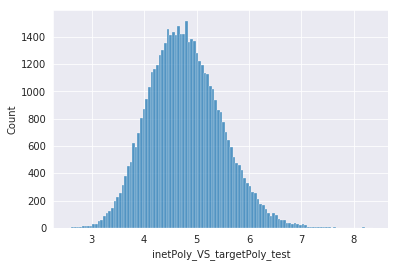

In [37]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'])


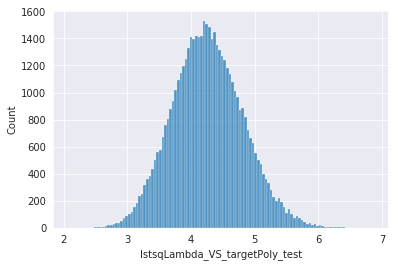

In [38]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'])


[(-30, 1)]

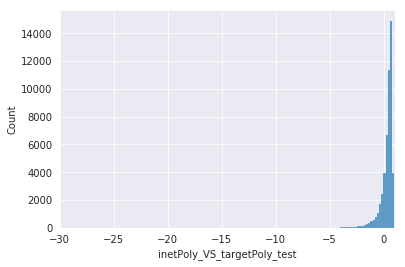

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0, 1)]

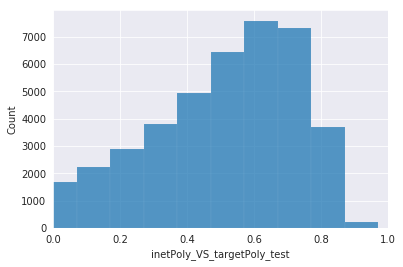

In [40]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10, 1)]

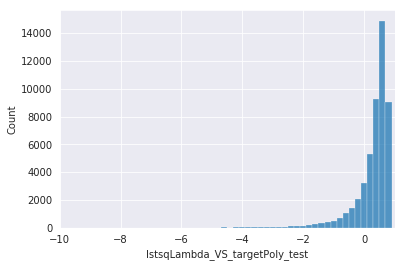

In [41]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0, 1)]

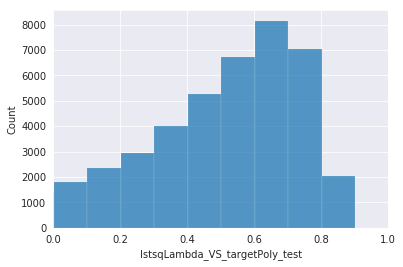

In [42]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'], binwidth=0.1)
p.set(xlim=(0, 1))

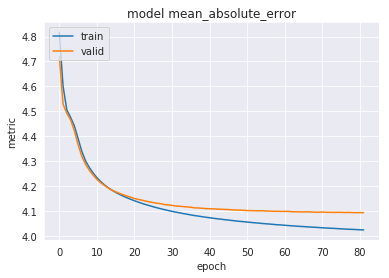

In [43]:
plt.plot(history[list(history.keys())[1]])
if consider_labels_training or evaluate_with_real_function:
    plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
plt.title('model ' + list(history.keys())[1])
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./data/results/' + interpretation_network_string + filename + '/metric_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


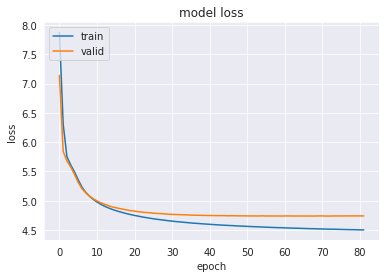

In [44]:
plt.plot(history['loss'])
if consider_labels_training or evaluate_with_real_function:
    plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

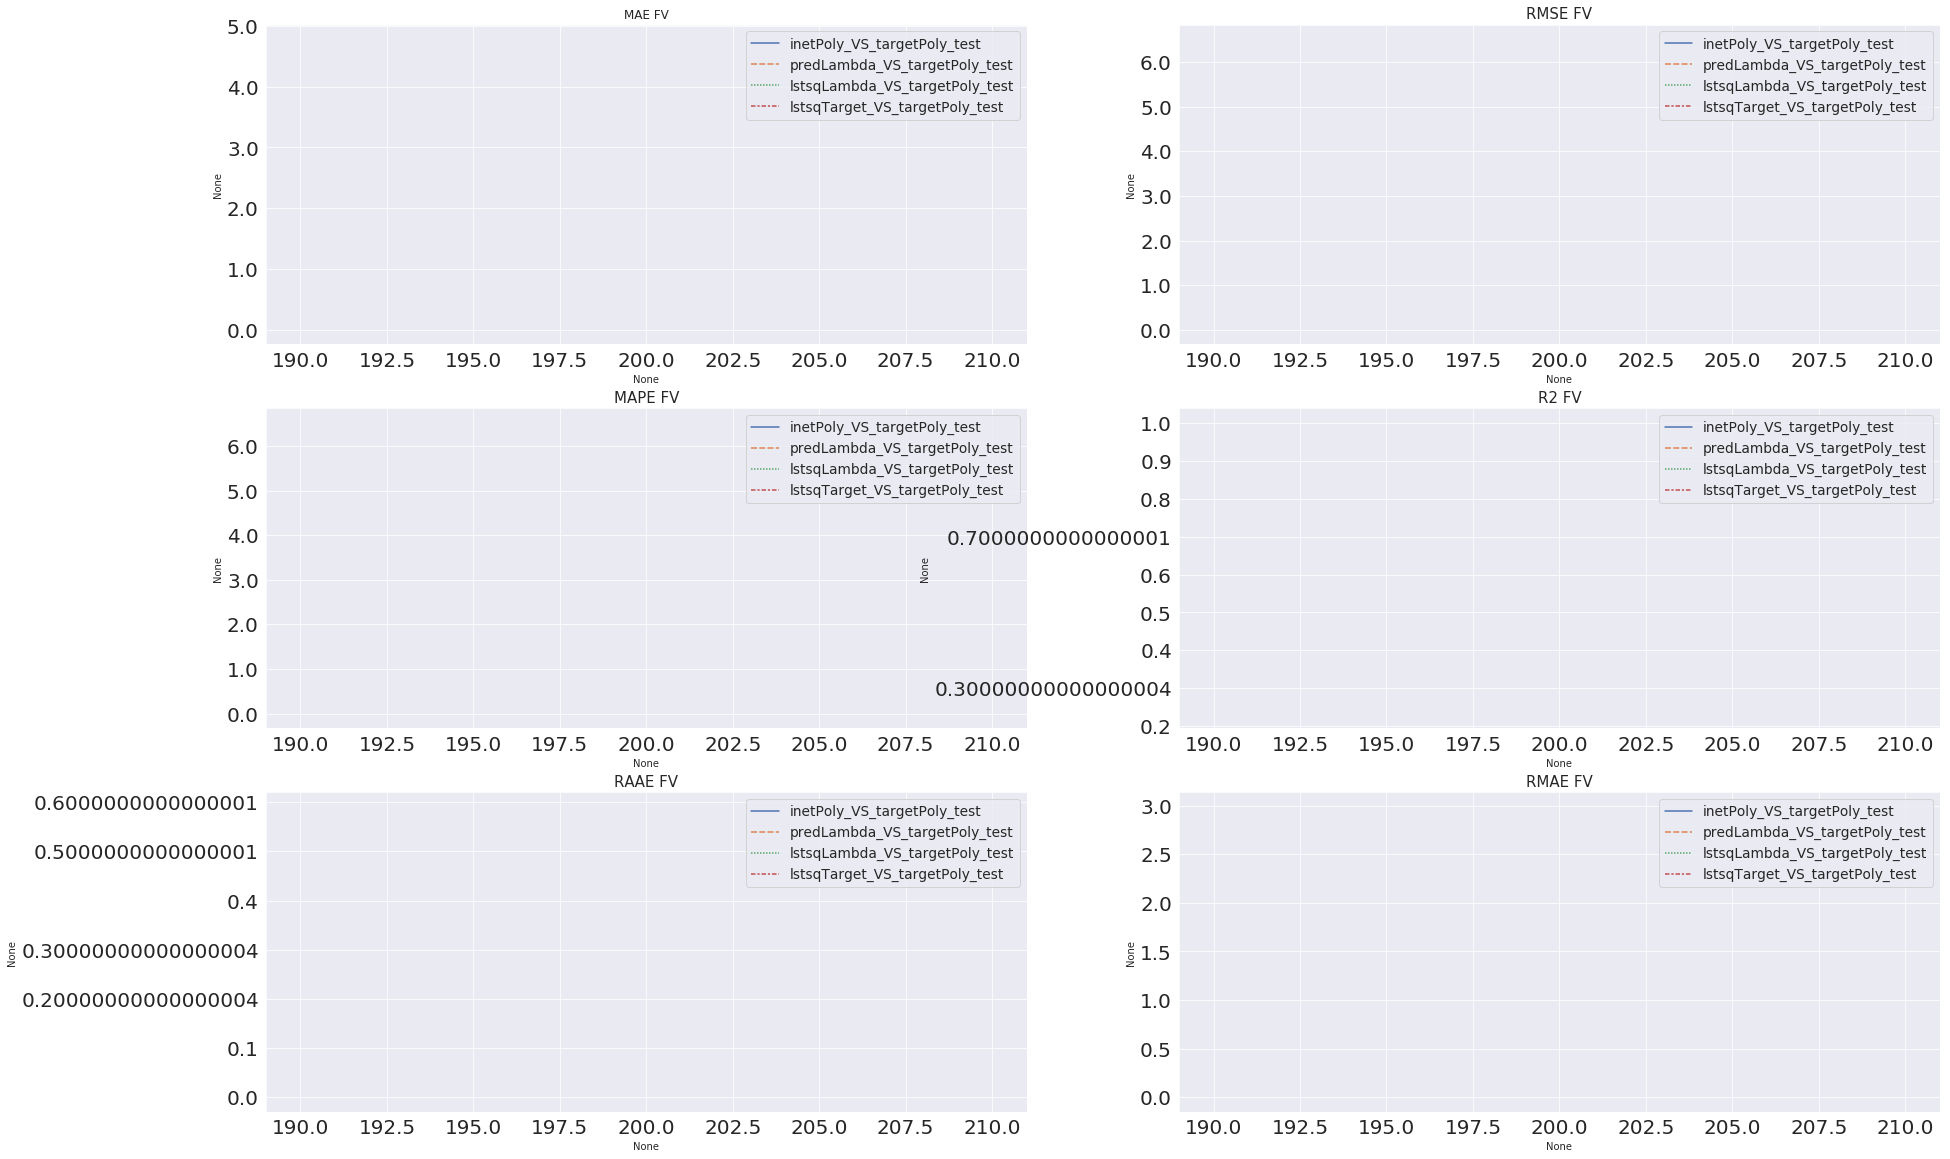

In [45]:
#Generate plot TEST PRED
plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

if samples_list == None:
    x_axis_steps = [(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda]
    x_max = epochs_lambda
else:
    x_axis_steps = samples_list
    x_max = samples_list[-1]
    
if evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    for index, metric in enumerate(plot_metric_list):

        inetPoly_VS_targetPoly_test = []
        #inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        #inetPoly_VS_lstsqLambda_test = []
        #lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_targetPoly_test.append(scores[metric].loc['inetPoly_VS_targetPoly_test'])
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])
            lstsqLambda_VS_targetPoly_test.append(scores[metric].loc['lstsqLambda_VS_targetPoly_test'])     
            lstsqTarget_VS_targetPoly_test.append(scores[metric].loc['lstsqTarget_VS_targetPoly_test'])
        
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_targetPoly_test, predLambda_VS_targetPoly_test, lstsqLambda_VS_targetPoly_test, lstsqTarget_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test'])

        ax[index//2, index%2].set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)        
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_REAL_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else:
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()
    
else:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    for index, metric in enumerate(plot_metric_list):

        #inetPoly_VS_targetPoly_test = []
        inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        inetPoly_VS_lstsqLambda_test = []
        lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        #lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        #lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_lstsqLambda_test.append(scores[metric].loc['inetPoly_VS_lstsqLambda_test'])
            inetPoly_VS_predLambda_test.append(scores[metric].loc['inetPoly_VS_predLambda_test'])
            lstsqLambda_VS_predLambda_test.append(scores[metric].loc['lstsqLambda_VS_predLambda_test'])     
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])     
            
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_predLambda_test, inetPoly_VS_lstsqLambda_test, lstsqLambda_VS_predLambda_test, predLambda_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test'])

        ax[index//2, index%2].set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)  

    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_MODEL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else: 
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()


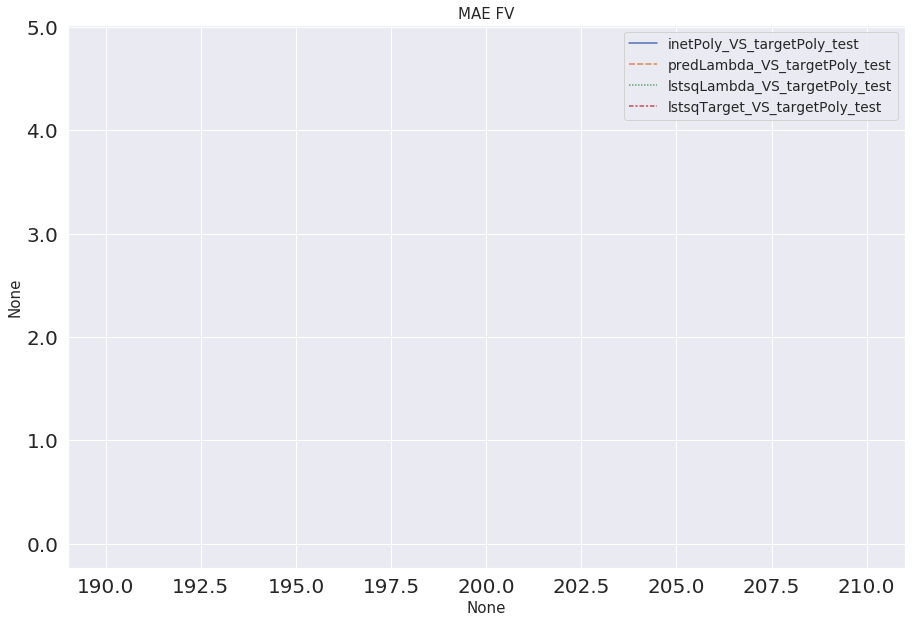

In [46]:
#Generate plot TEST PRED
plot_metric_list = ['MAE FV']

if samples_list == None:
    x_axis_steps = [(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda]
    x_max = epochs_lambda
else:
    x_axis_steps = samples_list
    x_max = samples_list[-1]
    
if evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    for index, metric in enumerate(plot_metric_list):

        inetPoly_VS_targetPoly_test = []
        #inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        #inetPoly_VS_lstsqLambda_test = []
        #lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_targetPoly_test.append(scores[metric].loc['inetPoly_VS_targetPoly_test'])
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])
            lstsqLambda_VS_targetPoly_test.append(scores[metric].loc['lstsqLambda_VS_targetPoly_test'])     
            lstsqTarget_VS_targetPoly_test.append(scores[metric].loc['lstsqTarget_VS_targetPoly_test'])
        
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_targetPoly_test, predLambda_VS_targetPoly_test, lstsqLambda_VS_targetPoly_test, lstsqTarget_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test'])

        ax.set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax)
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_REAL_' + metric + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else:
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()
    
else:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    for index, metric in enumerate(plot_metric_list):

        #inetPoly_VS_targetPoly_test = []
        inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        inetPoly_VS_lstsqLambda_test = []
        lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        #lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        #lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_lstsqLambda_test.append(scores[metric].loc['inetPoly_VS_lstsqLambda_test'])
            inetPoly_VS_predLambda_test.append(scores[metric].loc['inetPoly_VS_predLambda_test'])
            lstsqLambda_VS_predLambda_test.append(scores[metric].loc['lstsqLambda_VS_predLambda_test'])     
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])     
            
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_predLambda_test, inetPoly_VS_lstsqLambda_test, lstsqLambda_VS_predLambda_test, predLambda_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test'])

        ax.set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax)
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)

    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_MODEL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else: 
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()


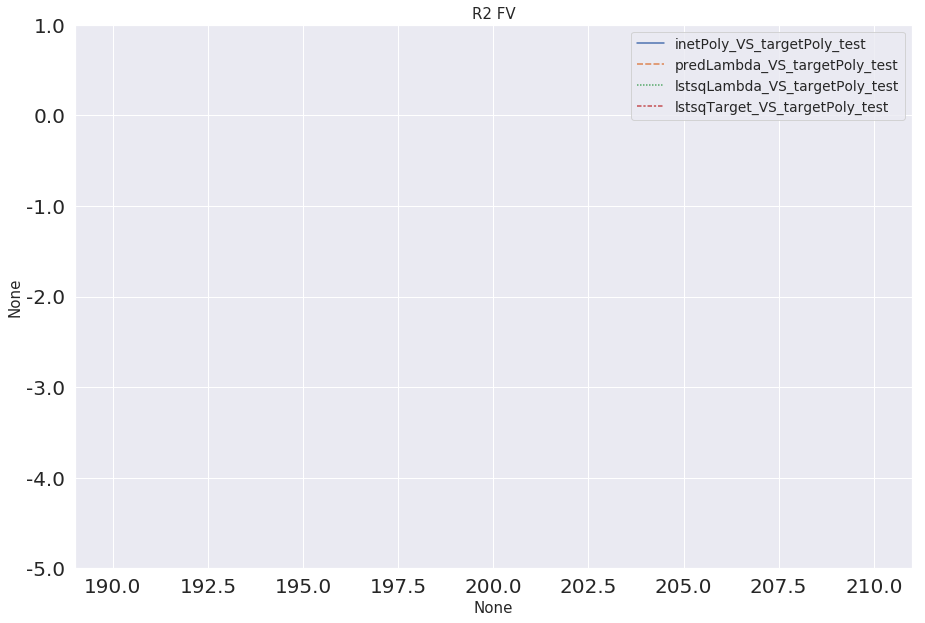

In [47]:
#Generate plot TEST PRED
plot_metric_list = ['R2 FV']

if samples_list == None:
    x_axis_steps = [(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda]
    x_max = epochs_lambda
else:
    x_axis_steps = samples_list
    x_max = samples_list[-1]
    
if evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    for index, metric in enumerate(plot_metric_list):

        inetPoly_VS_targetPoly_test = []
        #inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        #inetPoly_VS_lstsqLambda_test = []
        #lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_targetPoly_test.append(scores[metric].loc['inetPoly_VS_targetPoly_test'])
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])
            lstsqLambda_VS_targetPoly_test.append(scores[metric].loc['lstsqLambda_VS_targetPoly_test'])     
            lstsqTarget_VS_targetPoly_test.append(scores[metric].loc['lstsqTarget_VS_targetPoly_test'])
        
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_targetPoly_test, predLambda_VS_targetPoly_test, lstsqLambda_VS_targetPoly_test, lstsqTarget_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test'])

        ax.set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax)
        p.set(ylim=(-5, 1))
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_REAL_' + metric + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else:
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()
    
else:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    for index, metric in enumerate(plot_metric_list):

        #inetPoly_VS_targetPoly_test = []
        inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        inetPoly_VS_lstsqLambda_test = []
        lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        #lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        #lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_lstsqLambda_test.append(scores[metric].loc['inetPoly_VS_lstsqLambda_test'])
            inetPoly_VS_predLambda_test.append(scores[metric].loc['inetPoly_VS_predLambda_test'])
            lstsqLambda_VS_predLambda_test.append(scores[metric].loc['lstsqLambda_VS_predLambda_test'])     
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])     
            
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_predLambda_test, inetPoly_VS_lstsqLambda_test, lstsqLambda_VS_predLambda_test, predLambda_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test'])

        ax.set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax)
        p.set(ylim=(-5, 1))
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)

    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_MODEL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else: 
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()


#### Generate and Analyze Predictions for Random Function

In [48]:
rand_index = 42

lambda_model_preds = function_values_test_list[-1][0][rand_index].ravel()
real_poly_fvs = function_values_test_list[-1][1][rand_index]
lstsq_lambda_preds_poly = function_values_test_list[-1][2][rand_index]
lstsq_target_poly = function_values_test_list[-1][3][rand_index]
inet_poly_fvs = function_values_test_list[-1][4][rand_index]

    
x_vars = ['x' + str(i) for i in range(1, n+1)]

columns = x_vars.copy()
columns.append('FVs')

columns_single = x_vars.copy()

eval_size_plot = inet_poly_fvs.shape[0]
vars_plot = lambda_net_test_dataset_list[-1].test_data_list[rand_index]

    
if evaluate_with_real_function:
    columns_single.extend(['Lambda Model Preds', 'Target Poly FVs', 'LSTSQ Target Poly FVs', 'I-Net Poly FVs'])
    plot_data_single = pd.DataFrame(data=np.column_stack([vars_plot, lambda_model_preds, real_poly_fvs, lstsq_target_poly, inet_poly_fvs]), columns=columns_single)
    preds_plot_all = np.vstack([lambda_model_preds, real_poly_fvs, lstsq_target_poly, inet_poly_fvs]).ravel()
    vars_plot_all_preds = np.vstack([vars_plot for i in range(len(columns_single[n:]))])
    
    lambda_model_preds_str = np.array(['Lambda Model Preds' for i in range(eval_size_plot)])
    real_poly_fvs_str = np.array(['Target Poly FVs' for i in range(eval_size_plot)])
    lstsq_target_poly_str = np.array(['LSTSQ Target Poly FVs' for i in range(eval_size_plot)])
    inet_poly_fvs_str = np.array(['I-Net Poly FVs' for i in range(eval_size_plot)])
    
    identifier = np.concatenate([lambda_model_preds_str, real_poly_fvs_str, lstsq_target_poly_str, inet_poly_fvs_str])
else:
    columns_single.extend(['Lambda Model Preds', 'Target Poly FVs', 'LSTSQ Lambda Poly FVs', 'I-Net Poly FVs'])
    plot_data_single = pd.DataFrame(data=np.column_stack([vars_plot, lambda_model_preds, real_poly_fvs, lstsq_lambda_preds_poly, inet_poly_fvs]), columns=columns_single)
    preds_plot_all = np.vstack([lambda_model_preds, real_poly_fvs, lstsq_lambda_preds_poly, inet_poly_fvs]).ravel()
    vars_plot_all_preds = np.vstack([vars_plot for i in range(len(columns_single[n:]))])
    
    lambda_model_preds_str = np.array(['Lambda Model Preds' for i in range(eval_size_plot)])
    real_poly_fvs_str = np.array(['Target Poly FVs' for i in range(eval_size_plot)])
    lstsq_lambda_preds_poly_str = np.array(['LSTSQ Lambda Poly FVs' for i in range(eval_size_plot)])
    inet_poly_fvs_str = np.array(['I-Net Poly FVs' for i in range(eval_size_plot)])
    
    identifier = np.concatenate([lambda_model_preds_str, real_poly_fvs_str, lstsq_lambda_preds_poly_str, inet_poly_fvs_str])

plot_data = pd.DataFrame(data=np.column_stack([vars_plot_all_preds, preds_plot_all]), columns=columns)
plot_data['Identifier'] = identifier



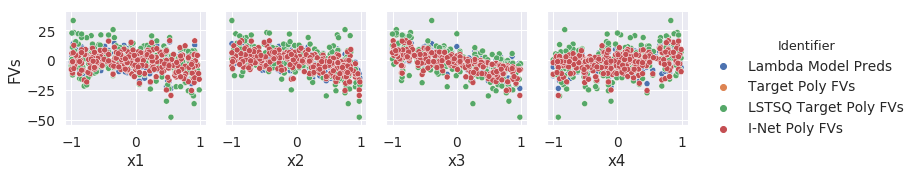

In [49]:
pp1 = sns.pairplot(data=plot_data,
                  #kind='reg',
                  hue='Identifier',
                  y_vars=['FVs'],
                  x_vars=x_vars)

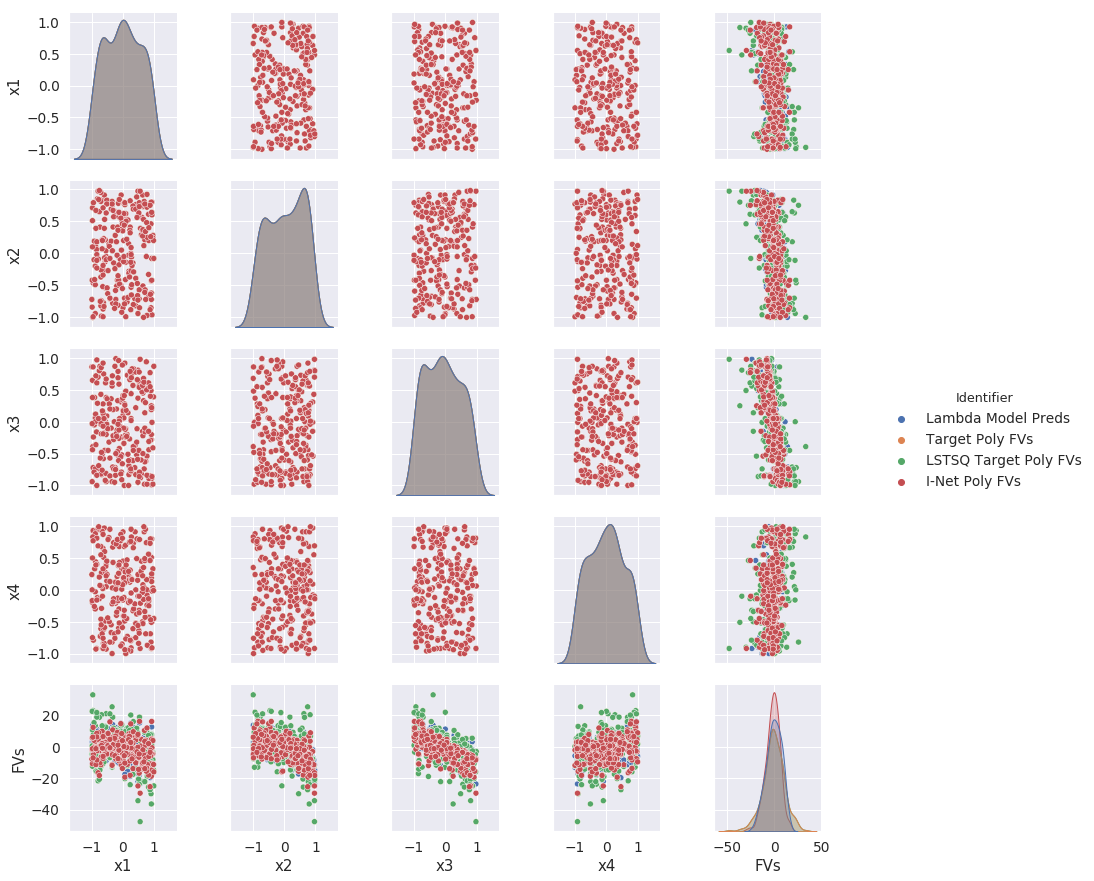

In [50]:
pp2 = sns.pairplot(data=plot_data,
                  #kind='reg',
                  hue='Identifier',
                  #y_vars=['FVs'],
                  #x_vars=x_vars
                 )

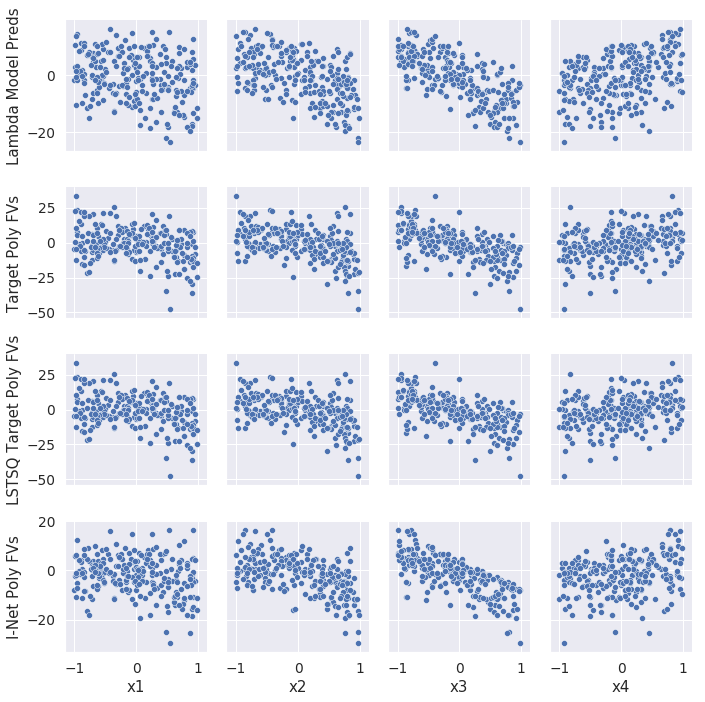

In [51]:
pp3 = sns.pairplot(data=plot_data_single,
                  #kind='reg',
                  y_vars=columns_single[n:],
                  x_vars=x_vars)

In [52]:
if evaluate_with_real_function:
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file1 = 'pp3in1_REAL_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file2 = 'pp3in1_extended_REAL_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file3 = 'pp1_REAL_' + str(rand_index) + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path1 = location + folder + file1
    path2 = location + folder + file2
    path3 = location + folder + file3
    
    pp1.savefig(path1, format='eps')
    pp2.savefig(path2, format='eps')
    pp3.savefig(path3, format='eps')
else:
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file1 = 'pp3in1_PRED_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file2 = 'pp3in1_extended_PRED_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file3 = 'pp1_PRED_' + str(rand_index) + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path1 = location + folder + file1
    path2 = location + folder + file2
    path3 = location + folder + file3
    
    pp1.savefig(path1, format='eps')
    pp2.savefig(path2, format='eps')
    pp3.savefig(path3, format='eps')    
    

# BENCHMARK (RANDOM GUESS) EVALUATION

In [53]:
list_of_random_polynomials = []
for i in range(len(lambda_net_test_dataset_list[-1])):
    random_polynomial = list(random_product([i*a_step for i in range(int(a_min*10**int(-np.log10(a_step))), int(a_max*10**int(-np.log10(a_step))))], repeat=nCr(n+d, d)))
    list_of_random_polynomials.append(random_polynomial)

In [54]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list)

In [55]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 6.669


In [56]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 14.423


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [57]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [58]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 10.2374


In [59]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True

